### Section 1: Import Data and Settings

In [9]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
import torch
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = './'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [5]:
def aggregate_diagnostic(y_dic):
    tmp = []
   #Y
   #  print(y_dic.keys())
    for key in y_dic.keys():
        if key in agg_df.index:
            #print("key", key)
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [6]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

### Section 2: Preprocessing

In [7]:
# variable to remove/set class balancing Section 2.2
balanced =False

#### Section 2.1 Train and Test Split Without any Preprocessing

In [30]:
test_fold = 10
val_fold=9
def split(X, Y, val_fold=9, test_fold=10):
    """
    Splits the dataset into train, validation, and test sets based on strat_fold.
    
    Parameters:
    - X: numpy array, input features.
    - Y: pandas DataFrame, containing labels and `strat_fold` column.
    - val_fold: int, fold to use for validation (default: 9).
    - test_fold: int, fold to use for testing (default: 10).
    
    Returns:
    - X_train, y_train: training data and labels.
    - X_val, y_val: validation data and labels.
    - X_test, y_test: test data and labels.
    """
    # Train
    X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
    y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].diagnostic_superclass

    # Validation
    X_val = X[Y.strat_fold == val_fold]
    y_val = Y[Y.strat_fold == val_fold].diagnostic_superclass

    # Test
    X_test = X[Y.strat_fold == test_fold]
    y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test=split(X, Y)
y_train.shape
X_train.shape

(17418, 5000, 12)

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def encode_filter(X_train, y_train, X_val, y_val, X_test, y_test, permute, oned):
    """
    Encodes and filters data, creating train, validation, and test DataLoaders.
    
    Parameters:
    - X_train, y_train, X_val, y_val, X_test, y_test: Input data and labels for train, val, and test sets.
    - permute: Boolean, whether to permute the tensor dimensions.
    - oned: Boolean, whether to squeeze the tensor for 1D input.
    
    Returns:
    - train_loader, val_loader, test_loader: DataLoaders for train, validation, and test sets.
    - y_train_encoded, y_val_encoded, y_test_encoded: Encoded labels for train, val, and test sets.
    """
    # Create label encoding
    unique_classes = list(set([item for sublist in y_train for item in sublist]))
    class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}

    # Filter and encode y_train
    y_train_filtered = [labels for labels in y_train if labels]
    X_train_filtered = X_train[np.array([bool(labels) for labels in y_train])]
    y_train_encoded = [class_to_idx[labels[0]] for labels in y_train_filtered]

    # Filter and encode y_val
    y_val_filtered = [labels for labels in y_val if labels]
    X_val_filtered = X_val[np.array([bool(labels) for labels in y_val])]
    y_val_encoded = [class_to_idx[labels[0]] for labels in y_val_filtered]

    # Filter and encode y_test
    y_test_filtered = [labels for labels in y_test if labels]
    X_test_filtered = X_test[np.array([bool(labels) for labels in y_test])]
    y_test_encoded = [class_to_idx[labels[0]] for labels in y_test_filtered]

    # Convert data to tensors
    def prepare_tensors(X_filtered, permute, oned):
        tensor = torch.tensor(X_filtered, dtype=torch.float32)
        if permute:
            tensor = tensor.unsqueeze(1).permute(0, 3, 2, 1)
        if oned:
            tensor = tensor.squeeze(dim=3)
        return tensor

    X_train_tensor = prepare_tensors(X_train_filtered, permute, oned)
    X_val_tensor = prepare_tensors(X_val_filtered, permute, oned)
    X_test_tensor = prepare_tensors(X_test_filtered, permute, oned)

    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

    print("X_train_tensor shape:", X_train_tensor.shape)
    print("X_val_tensor shape:", X_val_tensor.shape)
    print("X_test_tensor shape:", X_test_tensor.shape)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader, y_train_encoded, y_val_encoded, y_test_encoded, X_train_filtered, X_val_filtered, X_test_filtered, y_train_tensor


In [21]:
train_loader, val_loader, test_loader, y_train_encoded, y_val_encoded, y_test_encoded, X_train_filtered, X_val_filtered, X_test_filtered, y_train_tensor=encode_filter(X_train, y_train,  X_val, y_val, X_test, y_test, permute=True,oned=False)

X_train_tensor shape: torch.Size([17084, 12, 5000, 1])
X_val_tensor shape: torch.Size([2146, 12, 5000, 1])
X_test_tensor shape: torch.Size([2158, 12, 5000, 1])


In [22]:
train_loader_1d, val_loader_1d, test_loader_1d, y_train_encoded_1d, y_val_encoded_1d, y_test_encoded_1d, X_train_filtered_1d, X_val_filtered_1d, X_test_filtered_1d, y_train_tensor=encode_filter(X_train, y_train,  X_val, y_val, X_test, y_test, permute=True, oned=True)

X_train_tensor shape: torch.Size([17084, 12, 5000])
X_val_tensor shape: torch.Size([2146, 12, 5000])
X_test_tensor shape: torch.Size([2158, 12, 5000])


In [23]:
num_classes=len(y_train_tensor.unique())

#### Section 2.2 Handling Class Imbalance

In [24]:
from sklearn.utils import resample

def undersample_data(X, Y):
    df = pd.DataFrame({'class': Y['diagnostic_superclass'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'), 'index': np.arange(len(Y))})
    grouped = df.groupby('class')
    min_size = grouped.size().min()  # Size of the smallest class

    indices = grouped.apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)['index']
    indices = indices.values

    return X[indices], Y.iloc[indices]

X_balanced, Y_balanced = undersample_data(X, Y)
print(f"Shape of a balanced data: {X_balanced.shape}")


Shape of a balanced data: (2466, 5000, 12)


/tmp/ipykernel_1591413/3953435631.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = grouped.apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)['index']


#### Section 2.3 Artifact Removal

In [25]:
from scipy.signal import butter, filtfilt

def remove_powerline_noise(signal, fs=500, freq=50, Q=30):
    """
    Removes powerline noise using a Notch filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - freq: Frequency to be removed (50 or 60 Hz).
    - Q: Quality factor for the notch filter.
    
    Returns:
    - filtered_signal: Signal with powerline noise removed.
    """
    from scipy.signal import iirnotch

    nyquist = 0.5 * fs
    w0 = freq / nyquist  # Normalize frequency
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [26]:

def remove_baseline_wander(signal, fs=500, cutoff=0.5):
    """
    Removes baseline wander using a high-pass filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - cutoff: Cutoff frequency for the high-pass filter.
    
    Returns:
    - filtered_signal: Signal with baseline wander removed.
    """
    nyquist = 0.5 * fs
    b, a = butter(1, cutoff / nyquist, btype='high')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


In [27]:
def remove_high_frequency_noise(signal, fs=500, cutoff=40):
    """
    Removes high-frequency noise using a low-pass filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - cutoff: Cutoff frequency for the low-pass filter.
    
    Returns:
    - filtered_signal: Signal with high-frequency noise removed.
    """
    nyquist = 0.5 * fs
    b, a = butter(1, cutoff / nyquist, btype='low')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [28]:
def clean_ecg_data(X, fs=500):
    """
    Cleans a 3D ECG dataset (samples, time steps, leads) by removing artifacts.
    
    Args:
    - X: 3D array of shape (num_samples, signal_length, 12).
    - fs: Sampling frequency.
    
    Returns:
    - X_clean: 3D array of cleaned ECG data.
    """
    num_samples, signal_length, num_leads = X.shape
    X_clean = np.zeros_like(X)

    for sample_idx in range(num_samples):
        if sample_idx%1000==0:
            print("Sample_index:", sample_idx)
        for lead_idx in range(num_leads):
            signal = X[sample_idx, :, lead_idx]
            
            # Remove baseline wander
            signal = remove_baseline_wander(signal, fs=fs)
            # Remove powerline noise
            signal = remove_powerline_noise(signal, fs=fs, freq=50)  # Use 60 Hz for US data
            # Remove high-frequency noise
            signal = remove_high_frequency_noise(signal, fs=fs)

            # Store cleaned signal
            X_clean[sample_idx, :, lead_idx] = signal

    return X_clean


In [29]:
# clean the data
if balanced:
    X_cleaned = clean_ecg_data(X_balanced, fs=sampling_rate)
else:
    X_cleaned = clean_ecg_data(X, fs=sampling_rate)

if balanced:
    Y_cleaned=Y_balanced.copy()
else:
    Y_cleaned=Y.copy()


Sample_index: 0
Sample_index: 1000
Sample_index: 2000
Sample_index: 3000
Sample_index: 4000
Sample_index: 5000
Sample_index: 6000
Sample_index: 7000
Sample_index: 8000
Sample_index: 9000
Sample_index: 10000
Sample_index: 11000
Sample_index: 12000
Sample_index: 13000
Sample_index: 14000
Sample_index: 15000
Sample_index: 16000
Sample_index: 17000
Sample_index: 18000
Sample_index: 19000
Sample_index: 20000
Sample_index: 21000


In [31]:
X_train_clean, y_train_clean, X_val_clean, y_val_clean, X_test_clean, y_test_clean=split(X_cleaned, Y_cleaned)
y_train_clean.shape
X_train_clean.shape
train_loader_clean, val_loader_clean, test_loader_clean, y_train_encoded_clean, y_val_encoded_clean, y_test_encoded_clean, X_train_filtered_clean, X_val_filtered_clean, X_test_filtered_clean, y_train_tensor_clean=encode_filter(X_train_clean, y_train_clean,  X_val_clean, y_val_clean, X_test_clean, y_test_clean, permute=True, oned=False)

X_train_tensor shape: torch.Size([17084, 12, 5000, 1])
X_val_tensor shape: torch.Size([2146, 12, 5000, 1])
X_test_tensor shape: torch.Size([2158, 12, 5000, 1])


In [32]:
train_loader_clean_1d, val_loader_clean_1d, test_loader_clean_1d, y_train_encoded_clean_1d, y_val_encoded_clean_1d, y_test_encoded_clean_1d, X_train_filtered_clean_1d, X_val_filtered_clean_1d, X_test_filtered_clean_1d, y_train_tensor_clean_1d=encode_filter(X_train_clean, y_train_clean,  X_val_clean, y_val_clean, X_test_clean, y_test_clean, permute=True, oned=True)

X_train_tensor shape: torch.Size([17084, 12, 5000])
X_val_tensor shape: torch.Size([2146, 12, 5000])
X_test_tensor shape: torch.Size([2158, 12, 5000])


#### Section 2.4 Convert ECG Time series data to Spectrum to 2D image


In [33]:
from scipy.signal import stft

def ecg_to_spectrogram(ecg_signal, sampling_rate, nperseg=256, noverlap=None):
    """
    Converts a 1D ECG signal into a spectrogram using STFT.

    Args:
    - ecg_signal: 1D array, the ECG time-series signal.
    - fs: Sampling frequency.
    - nperseg: Number of samples per segment for STFT.
    - noverlap: Number of overlapping samples (default: None, usually nperseg//2).

    Returns:
    - f: Frequency bins.
    - t: Time bins.
    - Sxx: Spectrogram magnitude.
    """
    f, t, Zxx = stft(ecg_signal, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap)
    Sxx = np.abs(Zxx)  # Magnitude of the complex STFT
    return f, t, Sxx

In [34]:
import os

def process_all_samples(X, fs=500, save_images=False, output_dir="./spectrograms"):
    """
    Converts all ECG samples in X to spectrograms for 12 leads.

    Args:
    - X: 3D array of shape (num_samples, signal_length, 12).
    - fs: Sampling frequency.
    
    Returns:
    - all_spectrograms: List of spectrograms for all samples. 
      Shape: [(12, frequency_bins, time_bins) for each sample].
    """
    if save_images and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_spectrograms = []
    
    for sample_idx in range(X.shape[0]):
        sample_ecg = X[sample_idx]  # Shape: (signal_length, 12)
        sample_spectrograms = []
        if sample_idx%1000==0:
            print("Sample_index:", sample_idx)
        # Process each lead
        for lead in range(sample_ecg.shape[1]):
            ecg_signal = sample_ecg[:, lead]
            f, t, Sxx = ecg_to_spectrogram(ecg_signal, sampling_rate=sampling_rate)
            sample_spectrograms.append(Sxx)

        all_spectrograms.append(np.array(sample_spectrograms))  # Shape: (12, frequency_bins, time_bins)
    return all_spectrograms

In [35]:
all_spectrograms = process_all_samples(X_cleaned, sampling_rate)


# Print the shape of processed spectrograms
print(f"Processed {len(all_spectrograms)} samples with spectrograms for 12 leads.")
print(f"Shape of a single sample spectrogram: {all_spectrograms[0].shape}")

Sample_index: 0
Sample_index: 1000
Sample_index: 2000
Sample_index: 3000
Sample_index: 4000
Sample_index: 5000
Sample_index: 6000
Sample_index: 7000
Sample_index: 8000
Sample_index: 9000
Sample_index: 10000
Sample_index: 11000
Sample_index: 12000
Sample_index: 13000
Sample_index: 14000
Sample_index: 15000
Sample_index: 16000
Sample_index: 17000
Sample_index: 18000
Sample_index: 19000
Sample_index: 20000
Sample_index: 21000
Processed 21799 samples with spectrograms for 12 leads.
Shape of a single sample spectrogram: (12, 129, 41)


#### Section 2.5  Train and Test Split After Preprocessing Steps - 2.2 to 2.4

In [36]:
# Split into train and test based on strat_fold

# Training set
X_train_spec = np.array([
    all_spectrograms[i] for i in range(len(Y_cleaned))
    if Y_cleaned.iloc[i].strat_fold not in [test_fold, val_fold]
])
y_train_spec = [
    Y_cleaned.iloc[i].diagnostic_superclass for i in range(len(Y_cleaned))
    if Y_cleaned.iloc[i].strat_fold not in [test_fold, val_fold]
]

# Validation set
X_val_spec = np.array([
    all_spectrograms[i] for i in range(len(Y_cleaned))
    if Y_cleaned.iloc[i].strat_fold == val_fold
])
y_val_spec = [
    Y_cleaned.iloc[i].diagnostic_superclass for i in range(len(Y_cleaned))
    if Y_cleaned.iloc[i].strat_fold == val_fold
]

# Testing set
X_test_spec = np.array([
    all_spectrograms[i] for i in range(len(Y_cleaned))
    if Y_cleaned.iloc[i].strat_fold == test_fold
])
y_test_spec = [
    Y_cleaned.iloc[i].diagnostic_superclass for i in range(len(Y_cleaned))
    if Y_cleaned.iloc[i].strat_fold == test_fold
]



In [37]:
y_train_spec
X_train_spec.shape

(17418, 12, 129, 41)

In [38]:
train_loader_spec, val_loader_spec, test_loader_spec, y_train_encoded_spec, y_val_encoded_spec, y_test_encoded_spec, X_train_filtered_spec, X_val_filtered_spec, X_test_filtered_spec, y_train_tensor_spec=encode_filter(X_train_spec, y_train_spec,  X_val_spec, y_val_spec, X_test_spec, y_test_spec,permute=False,  oned=False)

X_train_tensor shape: torch.Size([17084, 12, 129, 41])
X_val_tensor shape: torch.Size([2146, 12, 129, 41])
X_test_tensor shape: torch.Size([2158, 12, 129, 41])


### Section 3: Visualization

#### Section 3.1: Plot multiple ECG signals in subplots

In [39]:
import matplotlib.pyplot as plt

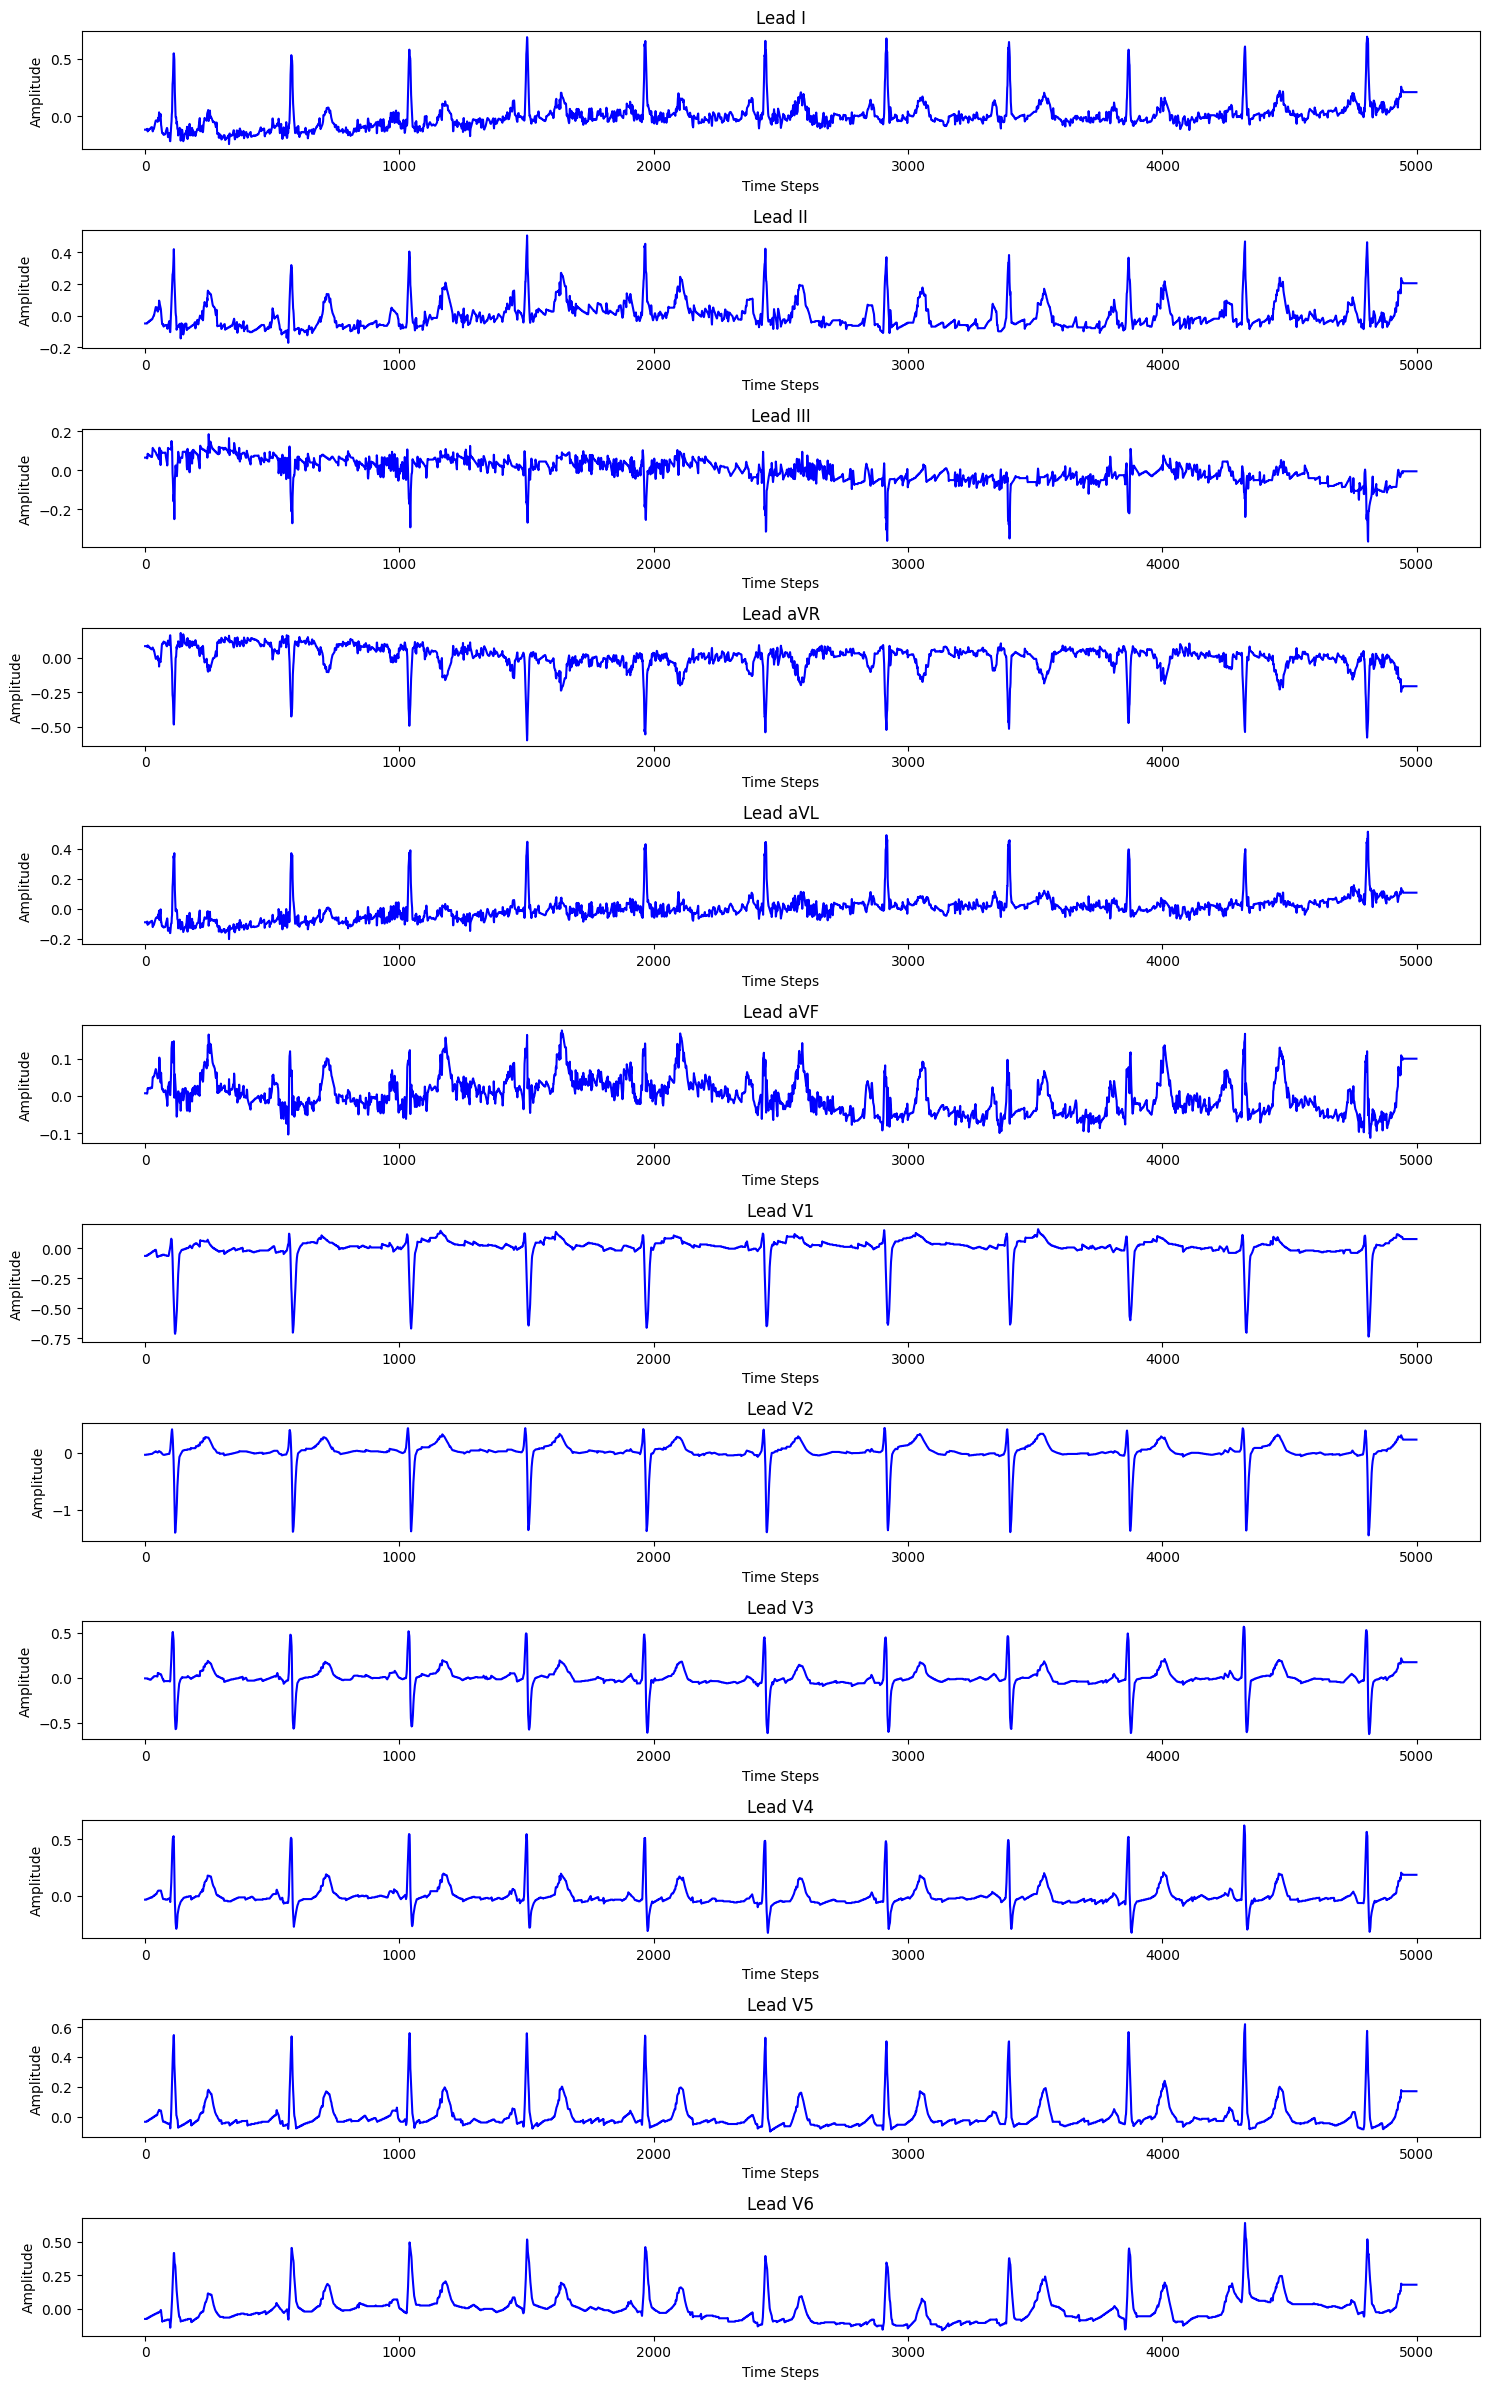

In [40]:
# Plot 12 channnels of first sample - original data
def plot_12_lead_ecg(ecg_data, sample_index=0, lead_names=None):
    if lead_names is None:
        lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    signal = ecg_data[sample_index]  
    num_leads = signal.shape[1]  
    
    plt.figure(figsize=(15, num_leads * 2))
    for lead in range(num_leads):
        plt.subplot(num_leads, 1, lead + 1)
        plt.plot(signal[:, lead], color='b')
        plt.title(f"Lead {lead_names[lead]}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.tight_layout()
    plt.show()

plot_12_lead_ecg(X, sample_index=0)


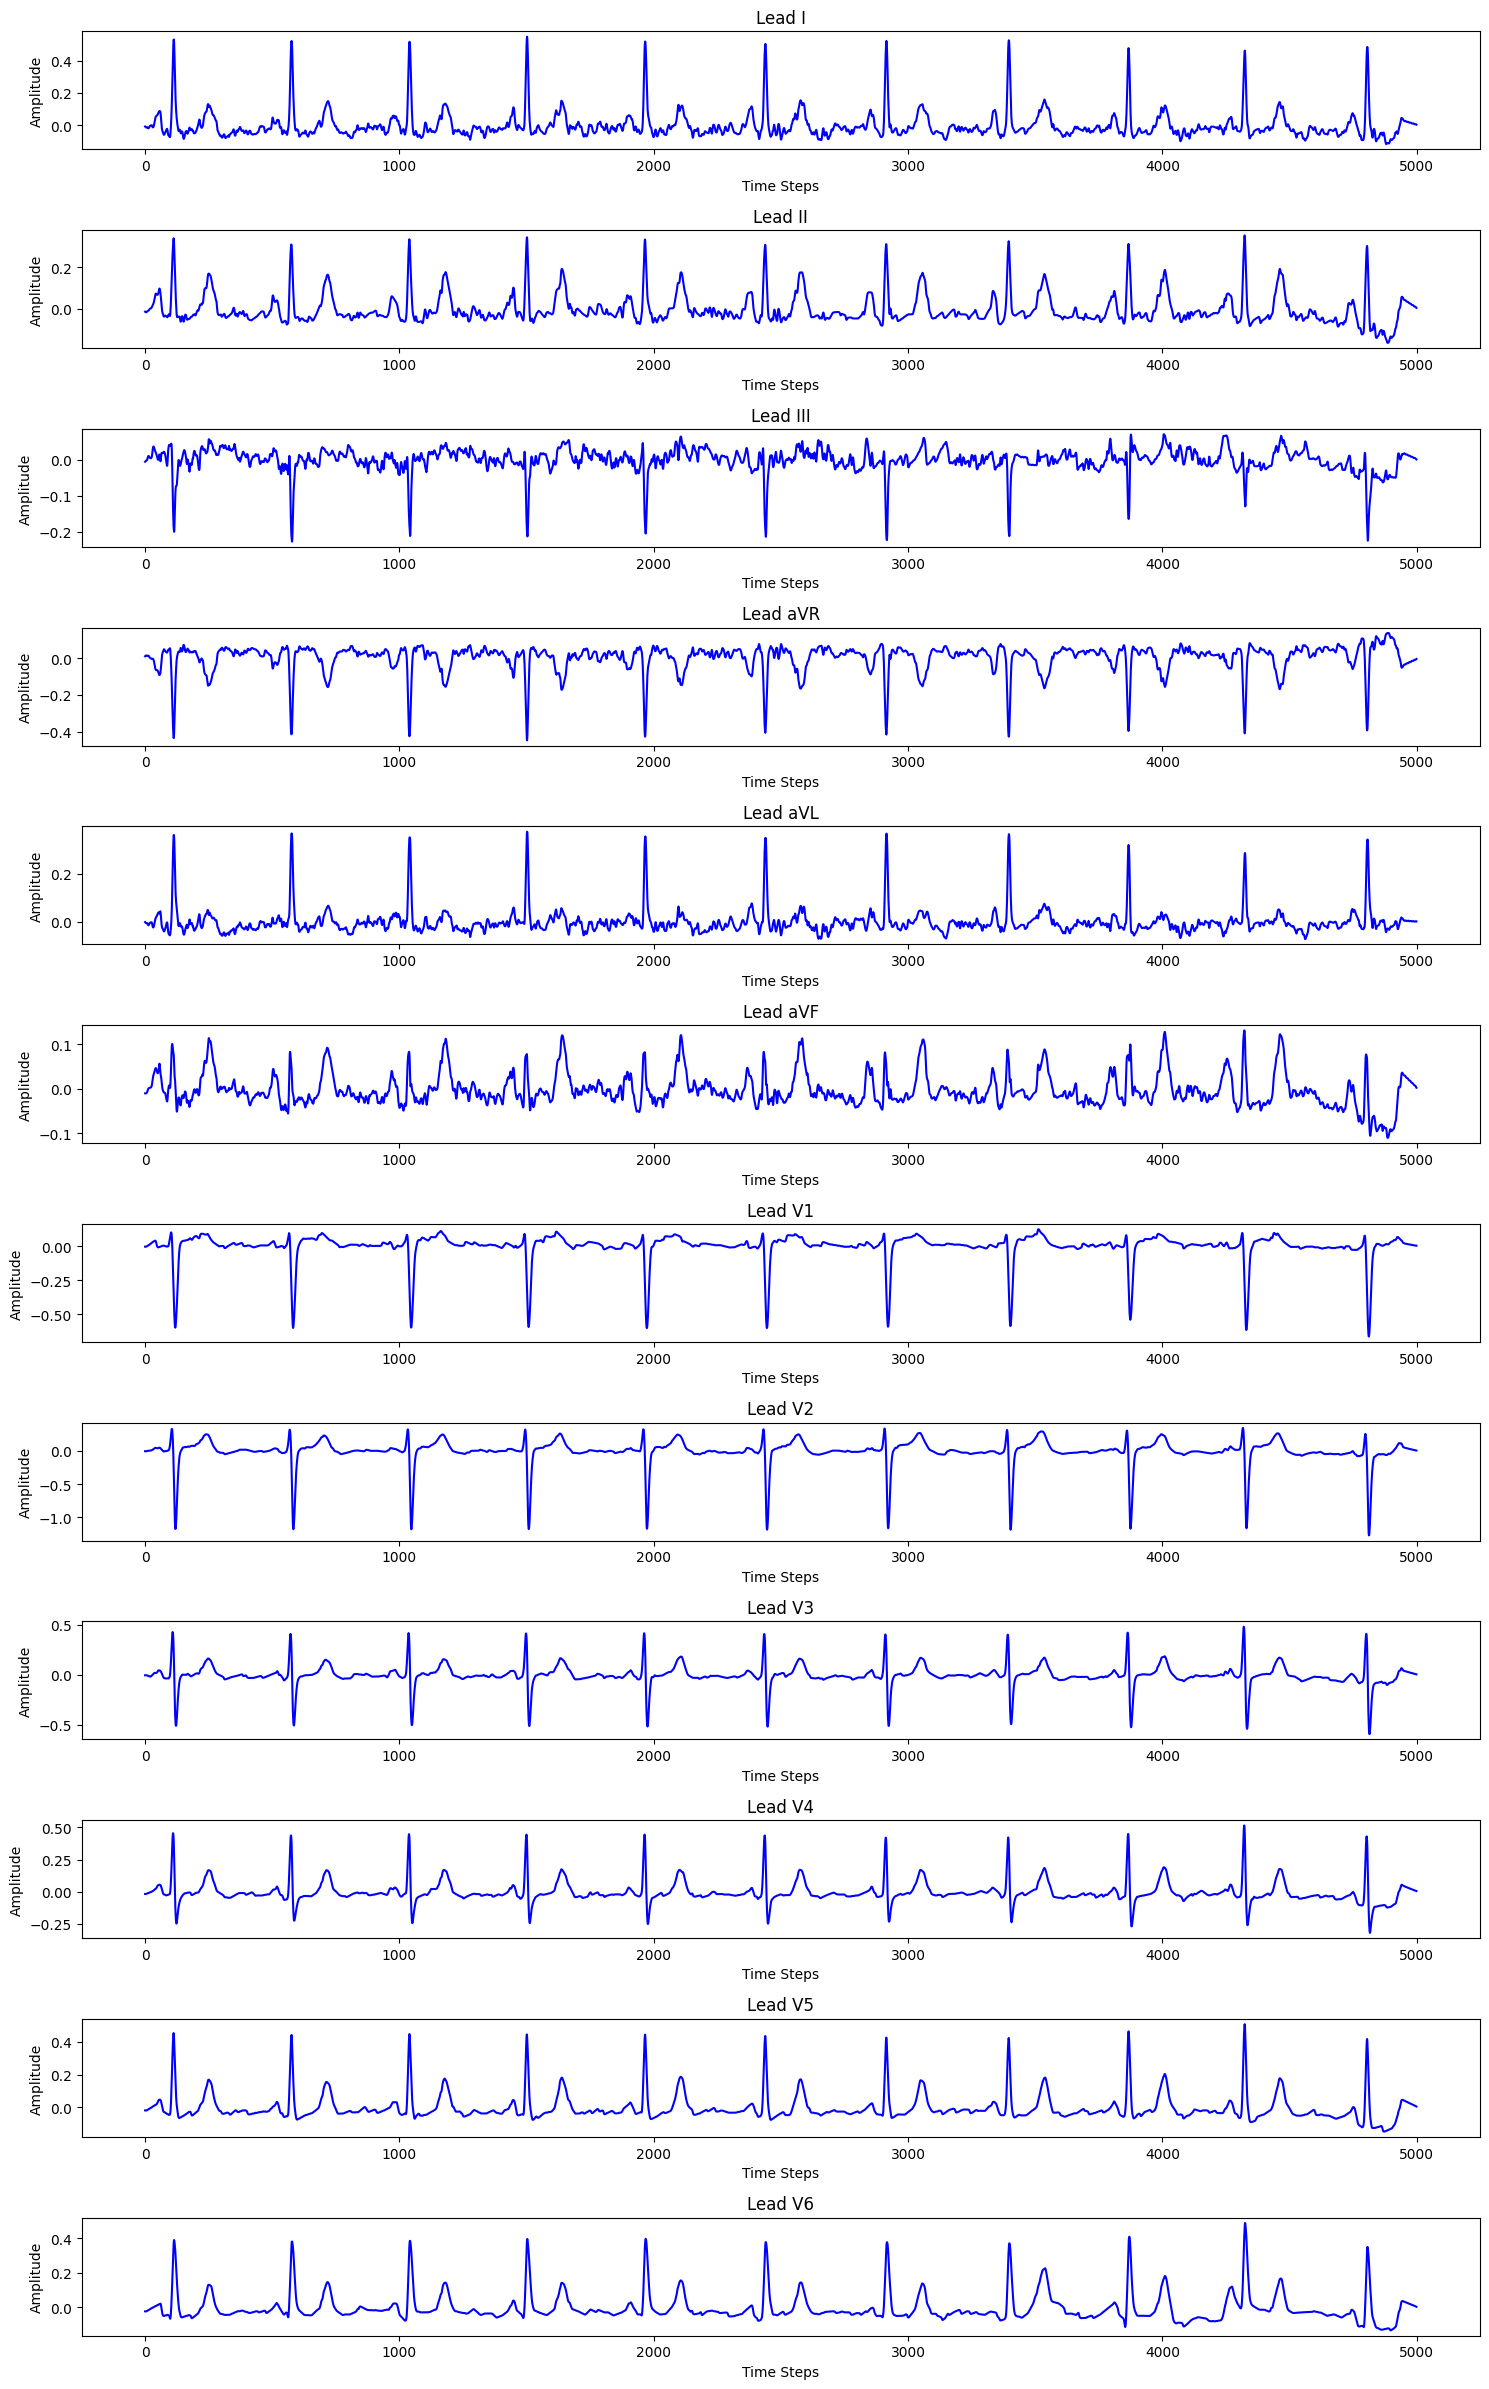

In [41]:
# Plot 12 channnels of first sample - Artifact cleaned data
plot_12_lead_ecg(X_cleaned, sample_index=0)

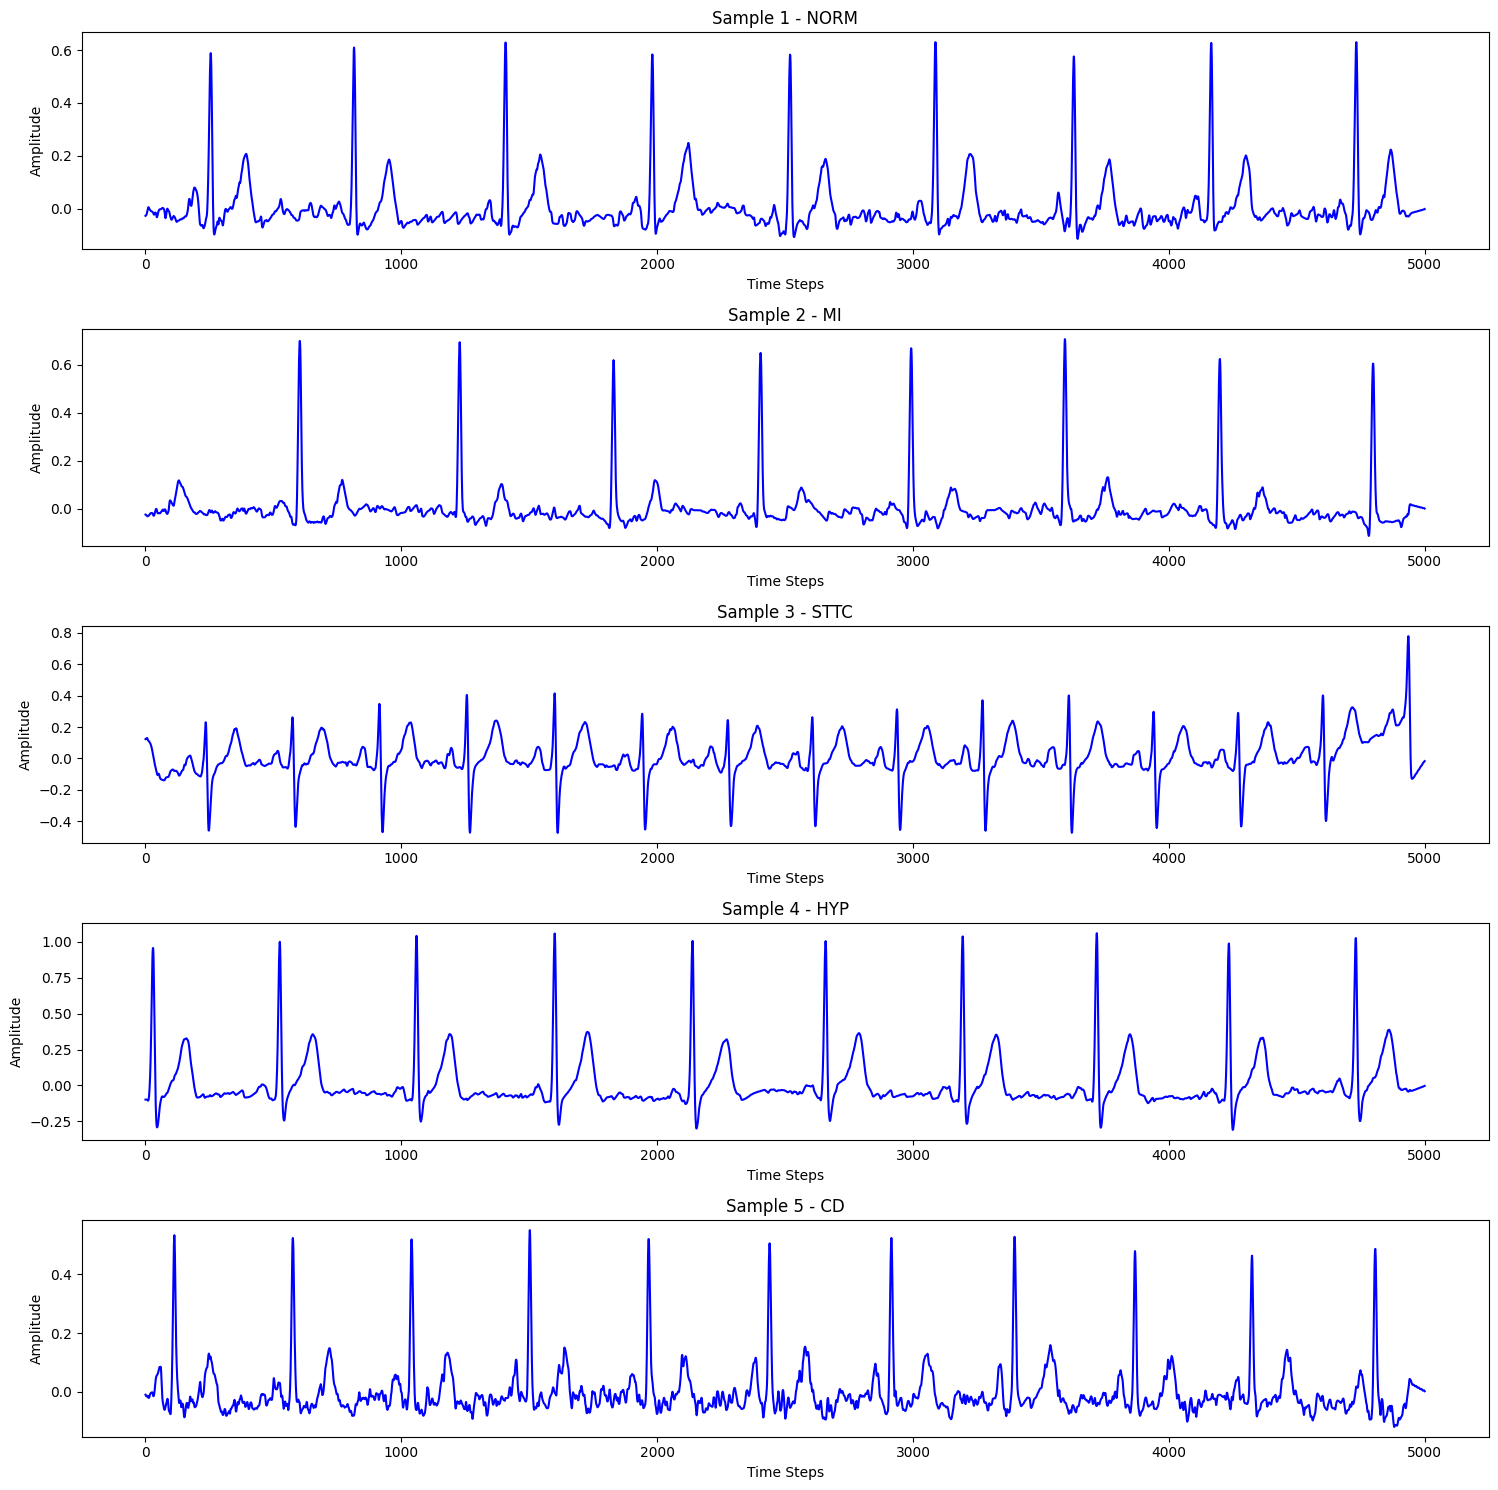

In [42]:
# Plot channel 1 of the sample of each class on balanced cleaned data

def plot_samples_with_classes(X, classes, num_samples=5, unique_classes=None):
    
    plt.figure(figsize=(15, num_samples * 3))
    for i, cls in enumerate(unique_classes[:num_samples]):
        idx = np.where(classes == cls)[0][0]  
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(X[idx][:,0], color='b')
        label = cls
        plt.title(f"Sample {i+1} - {label}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.tight_layout()
    plt.show()

plot_samples_with_classes(
    X_cleaned, 
    Y_balanced['diagnostic_superclass'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'
    ),
    num_samples=5, 
    unique_classes=["NORM", "MI", "STTC", "HYP", "CD"]
)




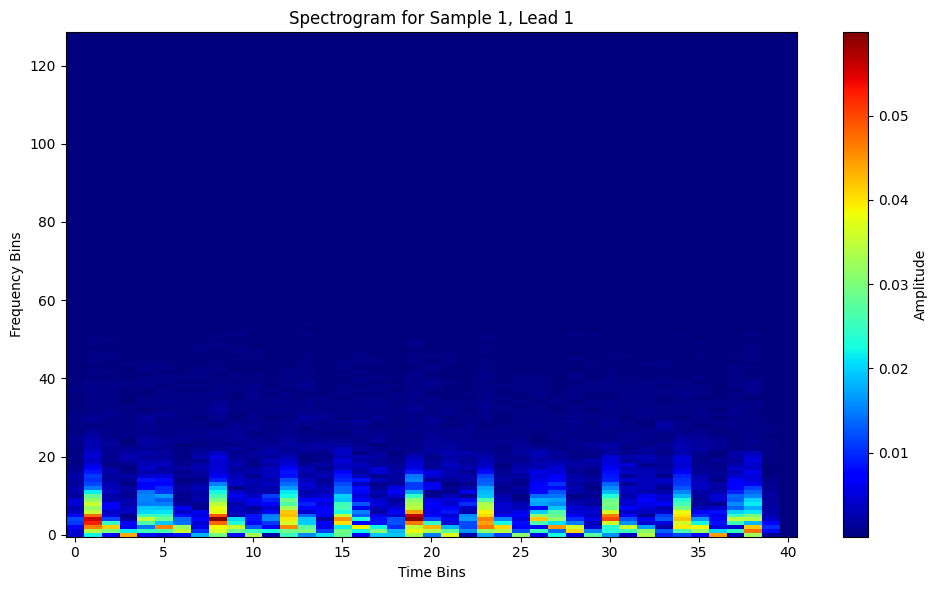

In [43]:
# Plot Spectrograms generated in section 2.4
def plot_spectrogram(spectrogram, sample_idx, lead_idx):
    """
    Plots a spectrogram for a specific sample and lead.
    
    Args:
    - spectrogram: List of spectrograms for all samples.
    - sample_idx: Index of the sample to plot.
    - lead_idx: Index of the lead to plot (0-11 for 12 leads).
    """
    spectrogram_data = spectrogram[sample_idx][lead_idx]  # Extract the specific lead's spectrogram

    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram_data, aspect='auto', origin='lower', cmap='jet')
    plt.title(f"Spectrogram for Sample {sample_idx + 1}, Lead {lead_idx + 1}")
    plt.ylabel("Frequency Bins")
    plt.xlabel("Time Bins")
    plt.colorbar(label="Amplitude")
    plt.tight_layout()
    plt.show()

plot_spectrogram(all_spectrograms, sample_idx=0, lead_idx=0)


#### Section 3.2: Class Distribution of diagnostic_superclass

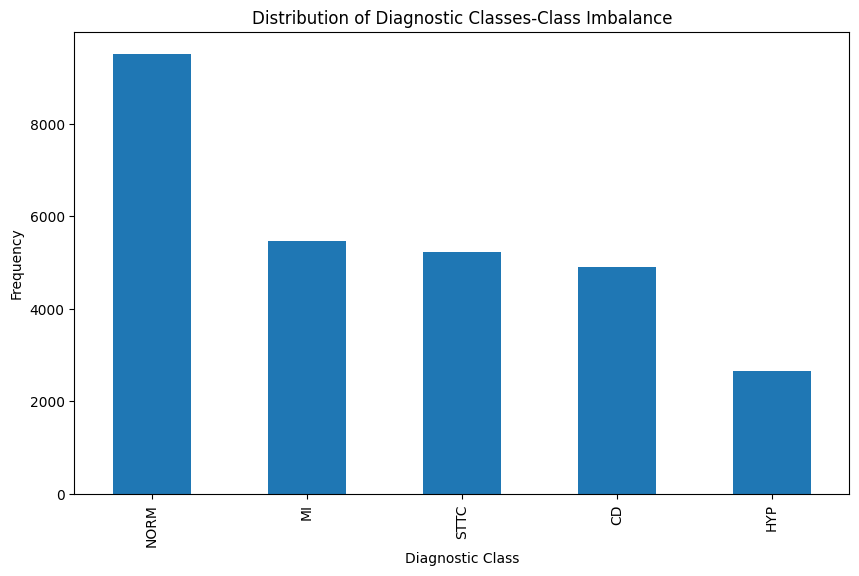

In [44]:
#Plot class distribution of imbalanced data
def plot_class_distribution(Y, plot_name):
    class_counts = Y['diagnostic_superclass'].explode().value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title("Distribution of Diagnostic Classes-"+ plot_name)
    plt.xlabel("Diagnostic Class")
    plt.ylabel("Frequency")
    plt.show()

plot_class_distribution(Y, "Class Imbalance")

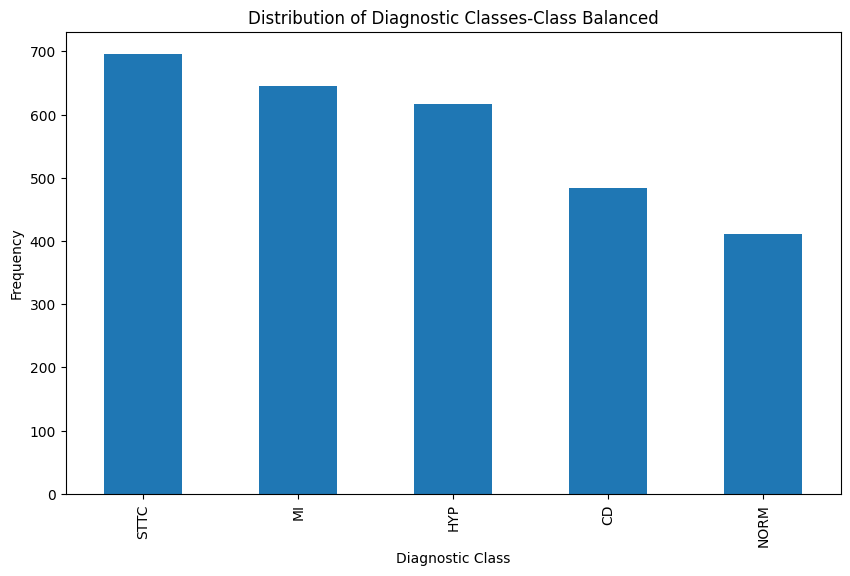

In [45]:
#Plot class distribution of balanced data
plot_class_distribution(Y_balanced, "Class Balanced")

#### Section 3.3 Demographic and Gender Distribution

In [46]:
import seaborn as sns

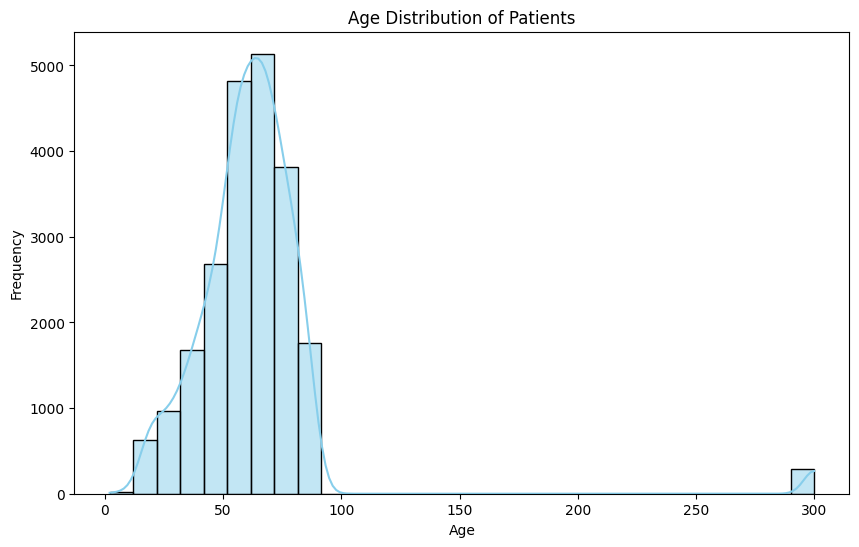

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(Y['age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_1591413/1404388577.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sex', data=Y, palette='Set2')


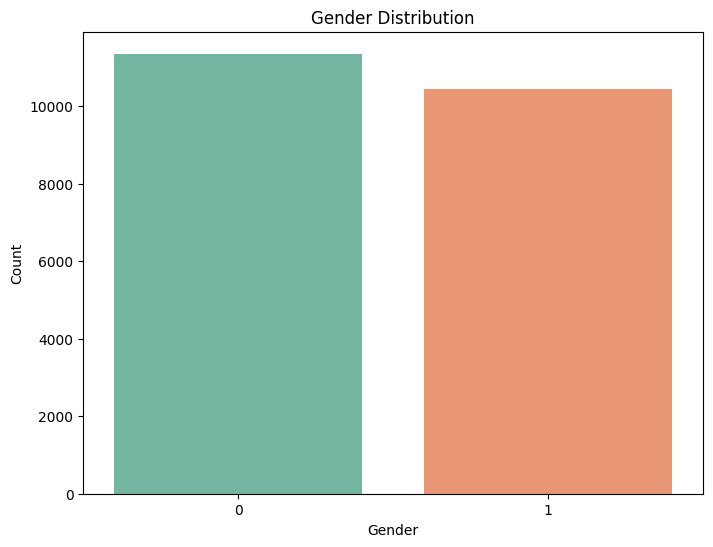

In [48]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=Y, palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

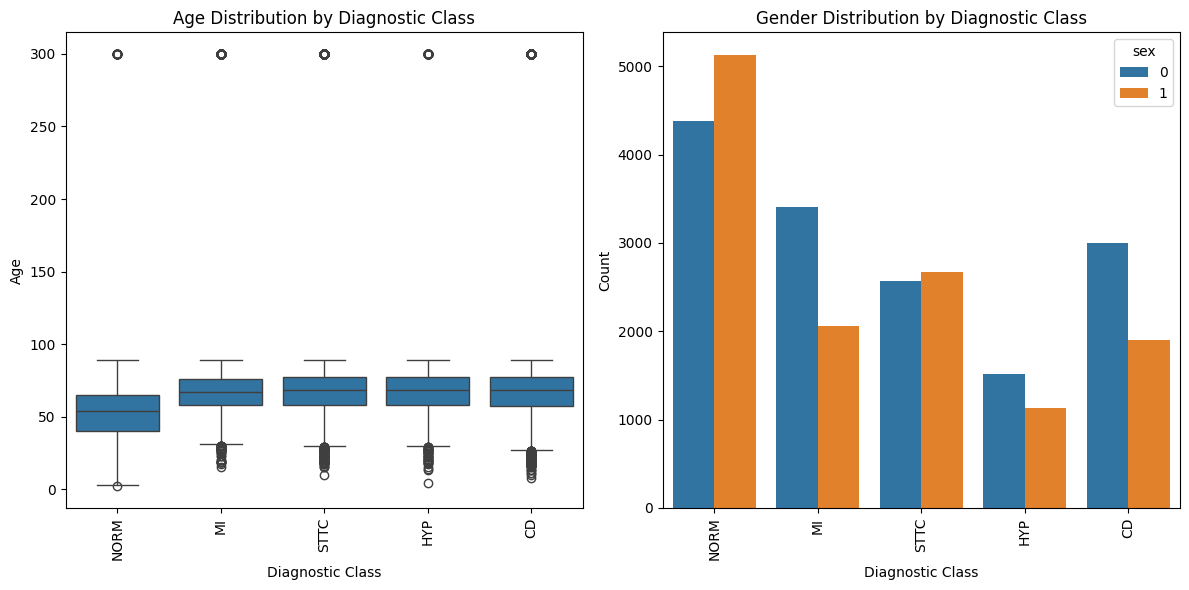

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

Y_exploded = Y.explode('diagnostic_superclass').reset_index(drop=True)

def plot_age_gender_distribution(Y):
    plt.figure(figsize=(12, 6))

    # Plot age distribution for each diagnostic class
    plt.subplot(1, 2, 1)
    sns.boxplot(data=Y, x='diagnostic_superclass', y='age')
    plt.title('Age Distribution by Diagnostic Class')
    plt.xlabel('Diagnostic Class')
    plt.ylabel('Age')
    plt.xticks(rotation=90)

    # Plot gender distribution by diagnostic class
    plt.subplot(1, 2, 2)
    sns.countplot(data=Y, x='diagnostic_superclass', hue='sex')
    plt.title('Gender Distribution by Diagnostic Class')
    plt.xlabel('Diagnostic Class')
    plt.ylabel('Count')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

plot_age_gender_distribution(Y_exploded)

#### Section 3.4: Feature Importance

In [50]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

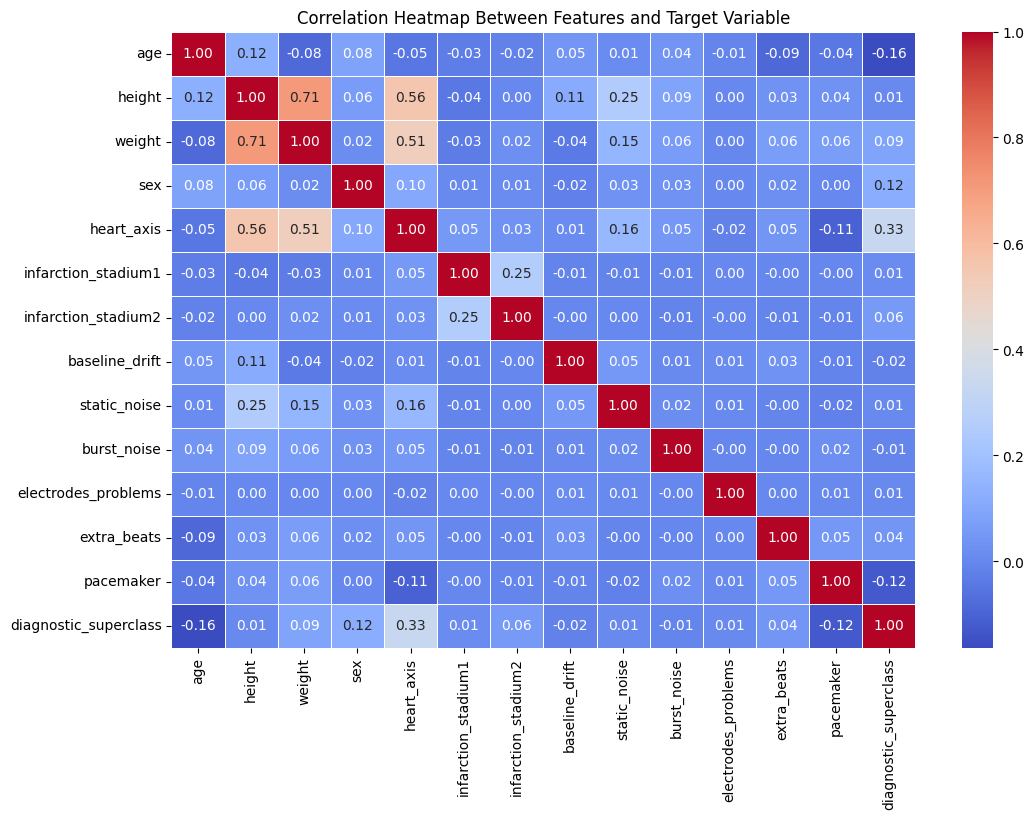

In [51]:
from sklearn.preprocessing import LabelEncoder

# Select numerical columns and check for non-numeric columns that may cause issues
numerical_columns = ['age', 'height', 'weight','sex']

Y_filled = Y.copy()
Y_filled[numerical_columns] = Y_filled[numerical_columns].fillna(0)

# Identify and exclude any non-numeric columns, encode categorical columns using label encoding or one-hot encoding
categorical_columns = ['heart_axis',  'infarction_stadium1', 'infarction_stadium2', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
                        'extra_beats', 'pacemaker', 'diagnostic_superclass']  

# For categorical columns, replace NaNs with 'no'
Y_filled[categorical_columns] = Y_filled[categorical_columns].fillna('no')

# Convert categorical columns to numeric representations

encoder = LabelEncoder()
for col in categorical_columns:
    Y_filled[col] = encoder.fit_transform(Y_filled[col].astype(str))

# Compute the correlation matrix on the numerical data only
corr_matrix = Y_filled[numerical_columns + categorical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap Between Features and Target Variable")
plt.show()


/tmp/ipykernel_1591413/2232586419.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.index, y=top_10_features.values, palette='coolwarm')


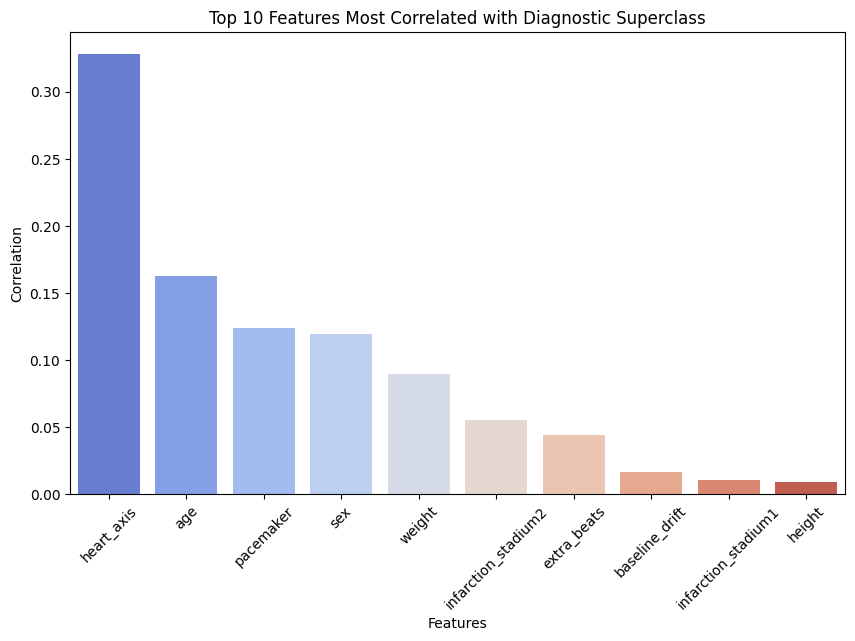

Top 10 features most correlated with diagnostic_superclass:
heart_axis             0.328067
age                    0.162946
pacemaker              0.123826
sex                    0.119034
weight                 0.089243
infarction_stadium2    0.055360
extra_beats            0.044243
baseline_drift         0.016482
infarction_stadium1    0.010827
height                 0.009248
Name: diagnostic_superclass, dtype: float64


In [52]:
# Get the correlation of each feature with diagnostic_superclass_numeric
correlation_with_target = corr_matrix['diagnostic_superclass'].drop('diagnostic_superclass')

# Get the top 10 most correlated features
top_10_features = correlation_with_target.abs().sort_values(ascending=False).head(10)

# Plot the top 10 most correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.index, y=top_10_features.values, palette='coolwarm')
plt.title("Top 10 Features Most Correlated with Diagnostic Superclass")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.show()

# Display the top 10 features
print("Top 10 features most correlated with diagnostic_superclass:")
print(top_10_features)

### Section 4: Train data using different models

#### Section 4.0 Generic Functions

In [70]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_num_epochs=40
criterion = nn.CrossEntropyLoss()

In [68]:
def print_info_data(model, y_train_encoded, y_test_encoded, X_train_filtered, num_classes):
    print(f"Number of classes: {num_classes}")
    print(f"Output layer size: {model.fc.out_features}")
    print("Unique encoded labels in y_train:", set(y_train_encoded))
    print("Unique encoded labels in y_test:", set(y_test_encoded))
    print("Length of X_train_filtered:", len(X_train_filtered))
    print("Length of y_train_encoded:", len(y_train_encoded))

In [ ]:
def train_model(model, train_loader, val_loader, device, max_num_epochs, criterion, optimizer):
    training_losses = []
    validation_losses = []
    f1_scores = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(max_num_epochs):
        model.train()
        running_loss = 0.0
        y_true_train = []
        y_pred_train = []

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(y_true_train, y_pred_train)
        training_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        y_true_val = []
        y_pred_val = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())

        # Calculate validation metrics
        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(y_true_val, y_pred_val)
        f1 = f1_score(y_true_val, y_pred_val, average='weighted')
        validation_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        f1_scores.append(f1)

        print(f"Epoch [{epoch + 1}/{max_num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, "
              f"Validation F1 Score: {f1:.4f}")

    return training_losses, validation_losses, f1_scores, train_accuracies, val_accuracies

In [56]:
def plot_loss_accuracy(training_losses, validation_losses, train_accuracies, val_accuracies, f1_scores=None):
    epochs = range(1, len(training_losses) + 1)

    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, training_losses, label='Training Loss', marker='o')
    plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.xticks(epochs)  # Optional: Show integers for epochs
    plt.show()

    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xticks(epochs)
    plt.show()

    # Plot F1 scores if available
    if f1_scores is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, f1_scores, label='Validation F1 Score', marker='o', color='purple')
        plt.title('F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.grid(True)
        plt.legend()
        plt.xticks(epochs)
        plt.show()

In [58]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_score, recall_score, f1_score, classification_report
)
from sklearn.preprocessing import label_binarize

def test_model(model, test_loader, device, n_classes):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    # Evaluate model
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(outputs.softmax(dim=1).cpu().numpy())

    # Convert to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Compute classification metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = (y_true == y_pred).mean() * 100

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

    # Compute ROC curve and AUC for each class
    y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure(figsize=(10, 7))
    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average ROC (AUC = {roc_auc['micro']:.3f})", color="deeppink", linestyle=":", linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} ROC (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Chance", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Per-Class and Micro-Average)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


#### Section 4.1: Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [60]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, roc_auc_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt

# Flatten and standardize data (assuming X_train and X_test are in shape [samples, time_steps])
X_train_flat = X_train_filtered.reshape(X_train_filtered.shape[0], -1)
X_test_flat = X_test_filtered.reshape(X_test_filtered.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Optionally apply PCA to reduce dimensionality (e.g., reduce to 50 components)
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# Initialize and train logistic regression
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train_reduced, y_train_encoded)

# Predict and evaluate on test data
y_pred = log_reg.predict(X_test_reduced)
y_pred_prob = log_reg.predict_proba(X_test_reduced)  # For ROC-AUC

# Metrics
precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1 Score: {f1:.2f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, zero_division=0))

/ece/home/nalla052/CSCI5980/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Overall Precision: 0.29
Overall Recall: 0.45
Overall F1 Score: 0.28
Test Accuracy: 44.76%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.44      0.01      0.02       429
           2       0.45      1.00      0.62       963
           3       0.00      0.00      0.00       335
           4       0.00      0.00      0.00       345

    accuracy                           0.45      2158
   macro avg       0.18      0.20      0.13      2158
weighted avg       0.29      0.45      0.28      2158



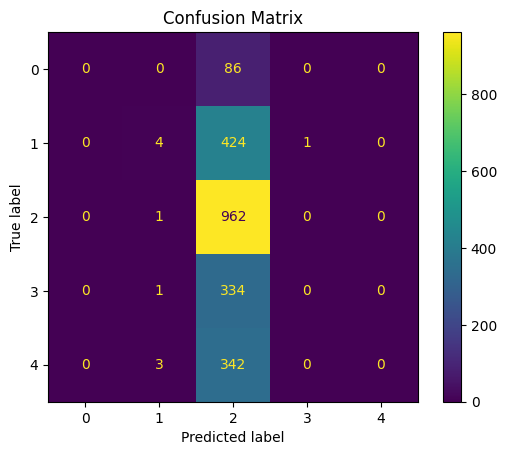

In [61]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred)
plt.title("Confusion Matrix")
plt.show()

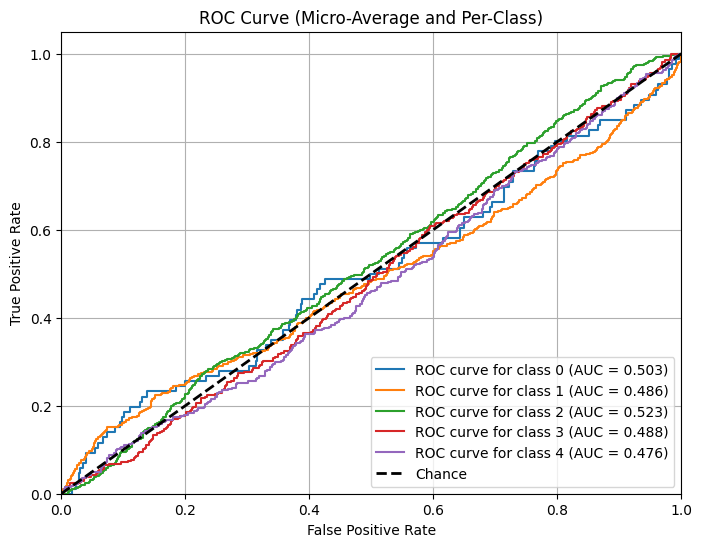

In [62]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize y_test for multiclass (e.g., classes are numbered 0 to n_classes-1)
n_classes = len(np.unique(y_test_encoded))
y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(n_classes))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))


# Plot ROC for each class
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"ROC curve for class {i} (AUC = {roc_auc[i]:.3f})",
    )

# Plot diagonal
plt.plot([0, 1], [0, 1], "k--", label="Chance", lw=2)

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro-Average and Per-Class)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Section 4.2: Resnet

In [65]:
def update_resnet_model(num_classes):
    # Load pre-trained ResNet model and modify for single-channel ECG data
    resnet = models.resnet18(pretrained=True)

    # Modify the first convolution layer to accept single channel input
    resnet.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


    # Modify the fully connected layer to match the number of diagnostic classes
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

    return resnet

##### Section 4.2.1 Resnet on raw ECG data

In [66]:
model_resnet = update_resnet_model(num_classes)
# Move model to device
model_resnet.to(device)
print(model_resnet)

/ece/home/nalla052/CSCI5980/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ece/home/nalla052/CSCI5980/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [69]:
print_info_data(model_resnet, y_train_encoded, y_test_encoded, X_train_filtered,num_classes)

Number of classes: 5
Output layer size: 5
Unique encoded labels in y_train: {0, 1, 2, 3, 4}
Unique encoded labels in y_test: {0, 1, 2, 3, 4}
Length of X_train_filtered: 17084
Length of y_train_encoded: 17084


In [71]:
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
training_losses, validation_losses, f1_scores, train_accuracies, val_accuracies=train_model(model_resnet, train_loader, val_loader, device, max_num_epochs, criterion, optimizer)

Epoch [1/40], Train Loss: 0.8979, Train Accuracy: 0.6779, Validation Loss: 0.7822, Validation Accuracy: 0.7097, Validation F1 Score: 0.6936
Epoch [2/40], Train Loss: 0.7521, Train Accuracy: 0.7323, Validation Loss: 0.7725, Validation Accuracy: 0.7181, Validation F1 Score: 0.6976
Epoch [3/40], Train Loss: 0.7124, Train Accuracy: 0.7423, Validation Loss: 0.7834, Validation Accuracy: 0.7185, Validation F1 Score: 0.7036
Epoch [4/40], Train Loss: 0.6826, Train Accuracy: 0.7526, Validation Loss: 0.7167, Validation Accuracy: 0.7330, Validation F1 Score: 0.7122
Epoch [5/40], Train Loss: 0.6571, Train Accuracy: 0.7580, Validation Loss: 0.6872, Validation Accuracy: 0.7316, Validation F1 Score: 0.7280
Epoch [6/40], Train Loss: 0.6368, Train Accuracy: 0.7661, Validation Loss: 0.7251, Validation Accuracy: 0.7311, Validation F1 Score: 0.7219
Epoch [7/40], Train Loss: 0.6230, Train Accuracy: 0.7690, Validation Loss: 0.6943, Validation Accuracy: 0.7363, Validation F1 Score: 0.7229
Epoch [8/40], Train 

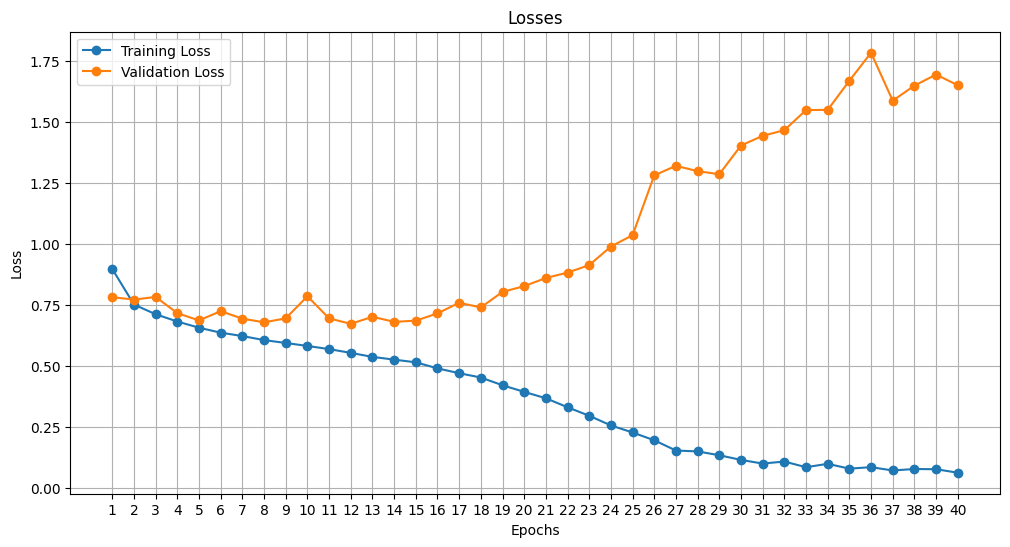

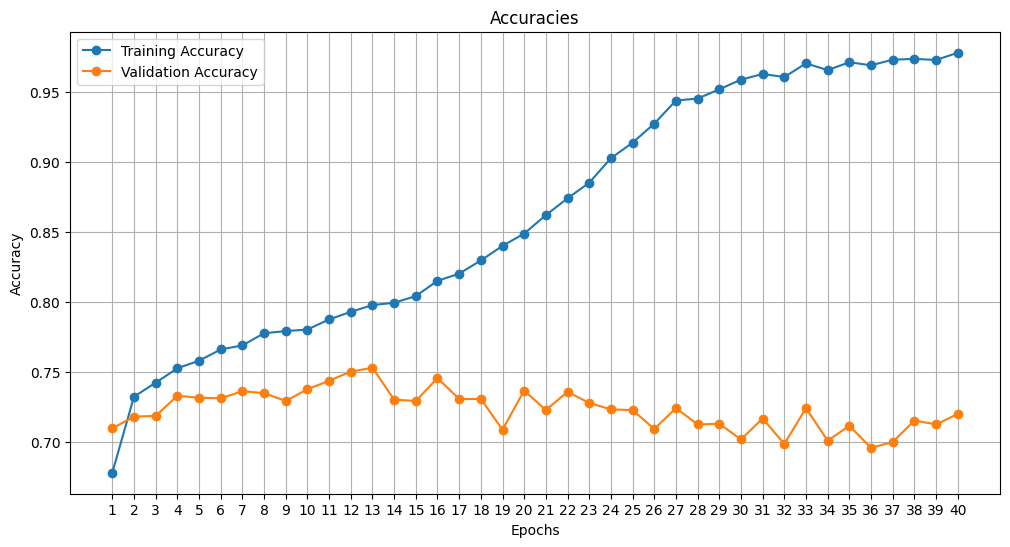

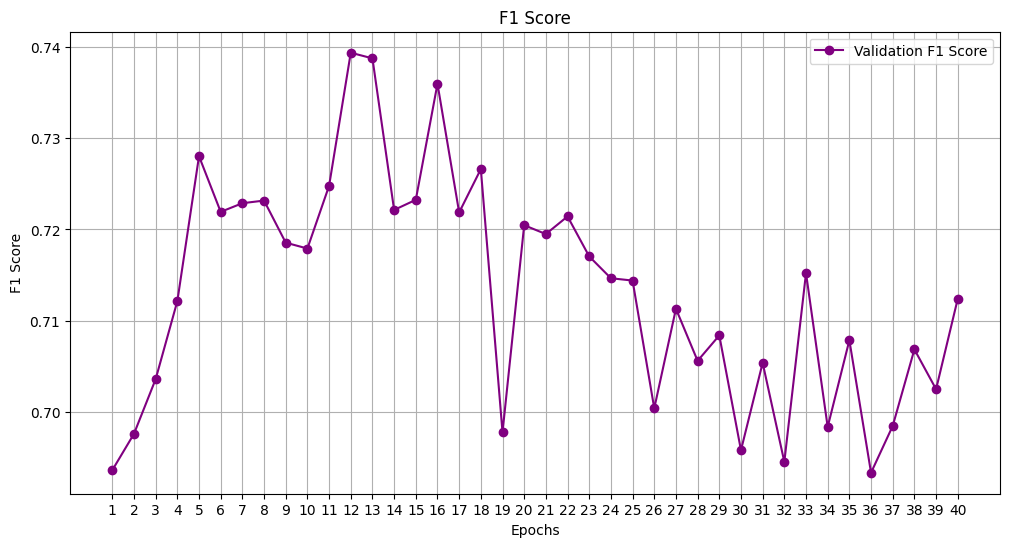

In [72]:
plot_loss_accuracy(training_losses, validation_losses, train_accuracies, val_accuracies, f1_scores)

Precision: 0.7049
Recall: 0.7187
F1 Score: 0.7087
Test Accuracy: 71.87%

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.12      0.16        86
           1       0.74      0.65      0.69       429
           2       0.80      0.89      0.84       963
           3       0.61      0.53      0.57       335
           4       0.61      0.66      0.63       345

    accuracy                           0.72      2158
   macro avg       0.60      0.57      0.58      2158
weighted avg       0.70      0.72      0.71      2158



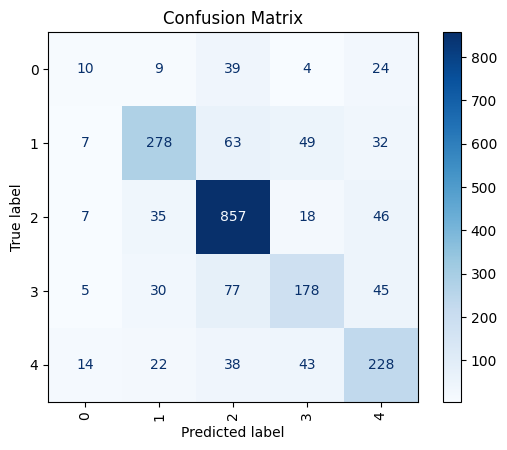

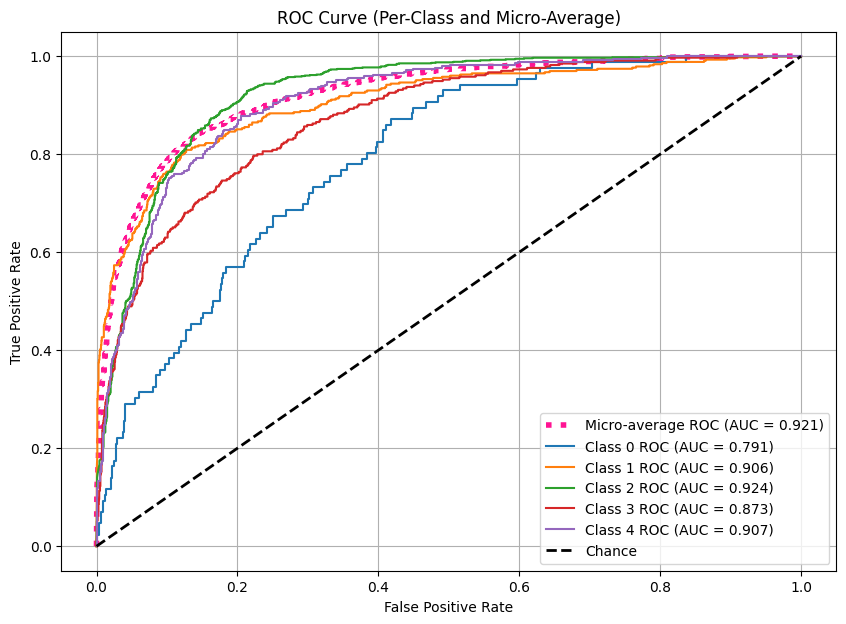

In [73]:
test_model(model_resnet, test_loader, device, num_classes)

##### Section 4.2.2 Resnet with Spectrograms

In [74]:
model_spec = update_resnet_model(num_classes)
# Move model to device
model_spec.to(device)
print(model_spec)

ResNet(
  (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

/ece/home/nalla052/CSCI5980/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ece/home/nalla052/CSCI5980/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
print_info_data(model_spec, y_train_encoded_spec, y_test_encoded_spec, X_train_filtered_spec, num_classes)

Number of classes: 5
Output layer size: 5
Unique encoded labels in y_train: {0, 1, 2, 3, 4}
Unique encoded labels in y_test: {0, 1, 2, 3, 4}
Length of X_train_filtered: 17084
Length of y_train_encoded: 17084


In [76]:
optimizer = optim.Adam(model_spec.parameters(), lr=0.001)
training_losses_spec, validation_losses_spec, f1_scores_spec, train_accuracies_spec, val_accuracies_spec=train_model(model_spec, train_loader_spec, val_loader_spec, device, max_num_epochs, criterion, optimizer)

Epoch [1/40], Train Loss: 1.0573, Train Accuracy: 0.6026, Validation Loss: 0.8823, Validation Accuracy: 0.6729, Validation F1 Score: 0.6420
Epoch [2/40], Train Loss: 0.9091, Train Accuracy: 0.6655, Validation Loss: 0.9439, Validation Accuracy: 0.6486, Validation F1 Score: 0.6191
Epoch [3/40], Train Loss: 0.8746, Train Accuracy: 0.6827, Validation Loss: 0.8690, Validation Accuracy: 0.6747, Validation F1 Score: 0.6535
Epoch [4/40], Train Loss: 0.8313, Train Accuracy: 0.6943, Validation Loss: 0.8438, Validation Accuracy: 0.6752, Validation F1 Score: 0.6389
Epoch [5/40], Train Loss: 0.8003, Train Accuracy: 0.7087, Validation Loss: 0.8688, Validation Accuracy: 0.6733, Validation F1 Score: 0.6587
Epoch [6/40], Train Loss: 0.7822, Train Accuracy: 0.7158, Validation Loss: 0.8210, Validation Accuracy: 0.6976, Validation F1 Score: 0.6810
Epoch [7/40], Train Loss: 0.7644, Train Accuracy: 0.7214, Validation Loss: 0.8436, Validation Accuracy: 0.6743, Validation F1 Score: 0.6708
Epoch [8/40], Train 

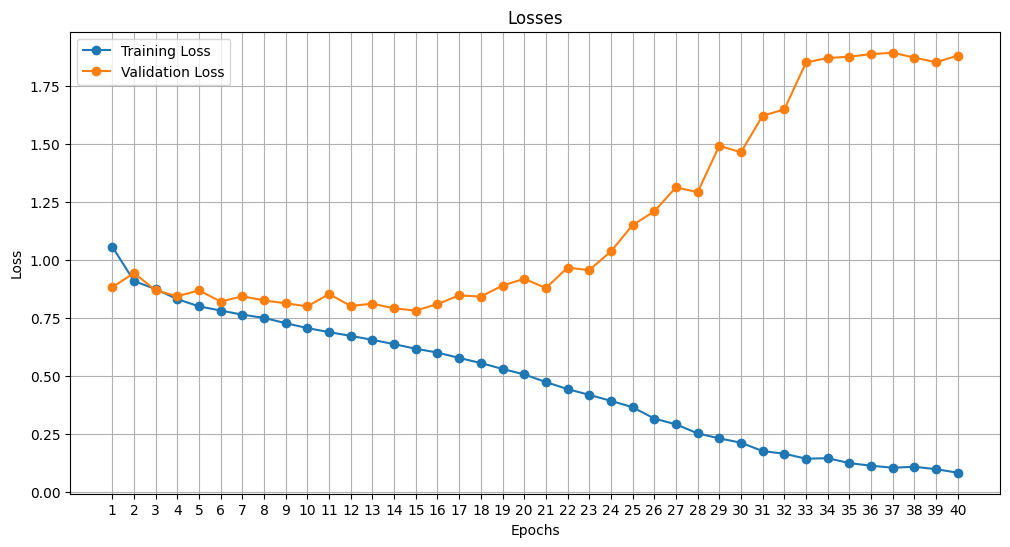

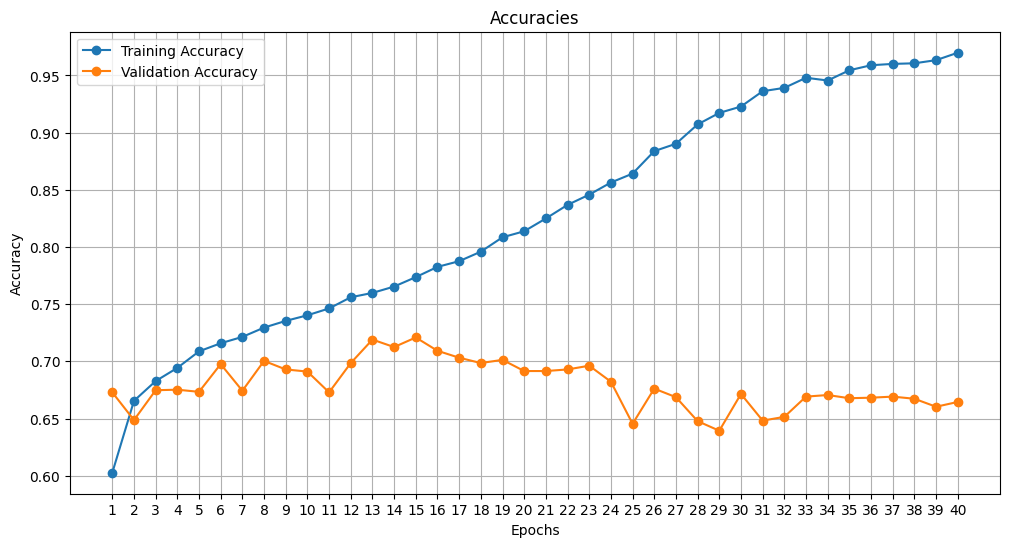

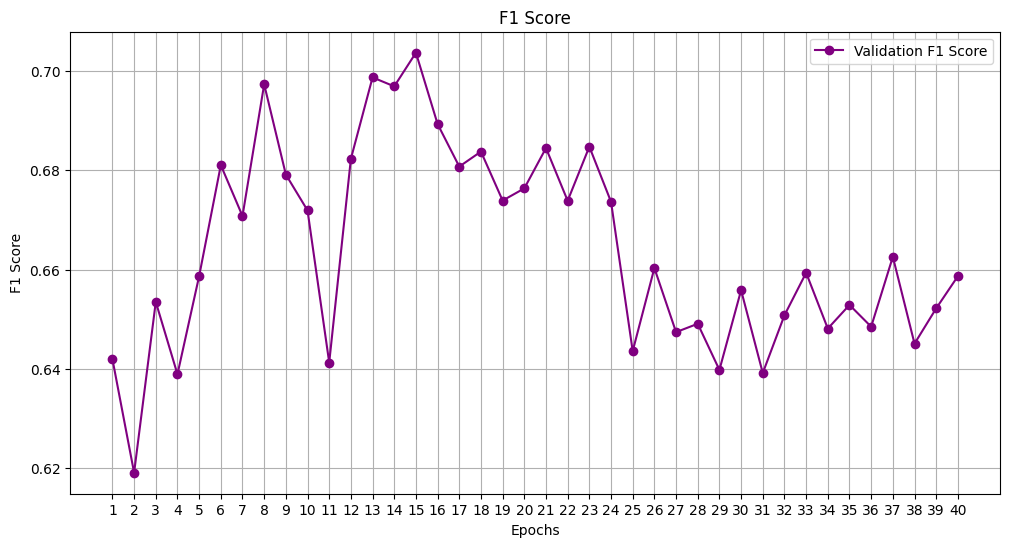

In [78]:
plot_loss_accuracy(training_losses_spec, validation_losses_spec, train_accuracies_spec, val_accuracies_spec, f1_scores_spec)

Precision: 0.6421
Recall: 0.6520
F1 Score: 0.6447
Test Accuracy: 65.20%

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.14      0.16        86
           1       0.69      0.59      0.63       429
           2       0.76      0.85      0.81       963
           3       0.45      0.46      0.46       335
           4       0.54      0.49      0.51       345

    accuracy                           0.65      2158
   macro avg       0.53      0.51      0.51      2158
weighted avg       0.64      0.65      0.64      2158



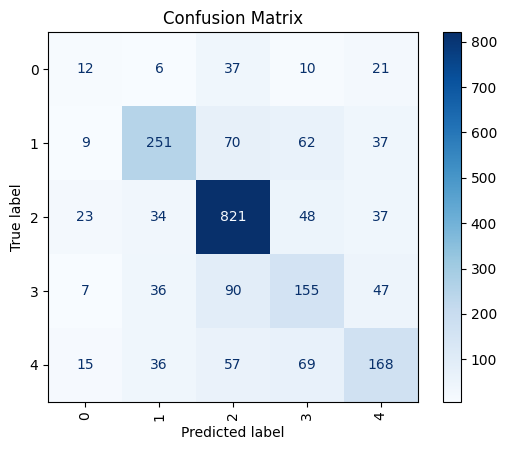

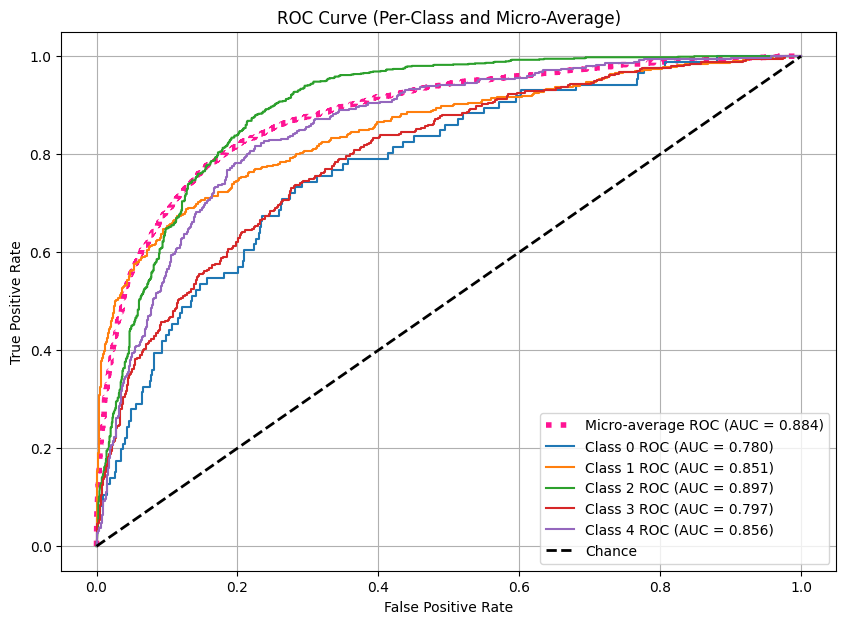

In [87]:
test_model(model_spec, test_loader_spec, device, num_classes)

#### Section 4.3 Resnet 1D - Custom

In [88]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18_1D(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18_1D, self).__init__()

        # Load the pretrained ResNet18 model
        resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolution layer to Conv1d (from Conv2d)
        resnet18.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify all Conv2d layers to Conv1d and BatchNorm2d to BatchNorm1d
        self._replace_conv2d_with_conv1d(resnet18)

        # Adjust the average pooling layer to work with 1D
        resnet18.avgpool = nn.AdaptiveAvgPool1d(1)

        # Define the fully connected layer (fc) to match the number of output classes
        resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

        # Store the modified ResNet18 model
        self.resnet18 = resnet18

    def _replace_conv2d_with_conv1d(self, model):
        """Recursively replace Conv2d with Conv1d and BatchNorm2d with BatchNorm1d in all layers of the ResNet18 model."""
        for name, module in model.named_children():
            if isinstance(module, nn.Conv2d):
                # Replace Conv2d with Conv1d
                in_channels = module.in_channels
                out_channels = module.out_channels
                kernel_size = module.kernel_size[0]  # Get the kernel size for 1D
                stride = module.stride[0]  # Get the stride for 1D
                padding = module.padding[0]  # Get the padding for 1D

                # Create new Conv1d layer
                new_conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
                setattr(model, name, new_conv)

            elif isinstance(module, nn.BatchNorm2d):
                # Replace BatchNorm2d with BatchNorm1d
                num_features = module.num_features
                new_bn = nn.BatchNorm1d(num_features)
                setattr(model, name, new_bn)

            elif isinstance(module, nn.MaxPool2d):
                # Replace MaxPool2d with MaxPool1d
                kernel_size = module.kernel_size  
                stride = module.stride 
                padding = module.padding  

                # Create new MaxPool1d layer
                new_pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
                setattr(model, name, new_pool)

            # Recursively handle Sequential and ModuleList containers
            elif isinstance(module, nn.Sequential):
                self._replace_conv2d_with_conv1d(module)
            elif isinstance(module, nn.ModuleList):
                for m in module:
                    self._replace_conv2d_with_conv1d(m)
            elif isinstance(module, nn.Module):
                self._replace_conv2d_with_conv1d(module)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [89]:
model_1d = ResNet18_1D(num_classes)
# Move model to device
model_1d.to(device)
print(model_1d)

ResNet18_1D(
  (resnet18): ResNet(
    (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [90]:
optimizer = optim.Adam(model_1d.parameters(), lr=0.001)
training_losses_1d, validation_losses_1d, f1_scores_1d, train_accuracies_1d, val_accuracies_1d=train_model(model_1d, train_loader_1d, val_loader_1d, device, max_num_epochs, criterion, optimizer)

Epoch [1/40], Train Loss: 0.9149, Train Accuracy: 0.6703, Validation Loss: 1.1285, Validation Accuracy: 0.5694, Validation F1 Score: 0.5876
Epoch [2/40], Train Loss: 0.7790, Train Accuracy: 0.7226, Validation Loss: 0.8299, Validation Accuracy: 0.7144, Validation F1 Score: 0.6895
Epoch [3/40], Train Loss: 0.7389, Train Accuracy: 0.7377, Validation Loss: 0.7943, Validation Accuracy: 0.7013, Validation F1 Score: 0.6834
Epoch [4/40], Train Loss: 0.7072, Train Accuracy: 0.7474, Validation Loss: 0.8104, Validation Accuracy: 0.7269, Validation F1 Score: 0.7006
Epoch [5/40], Train Loss: 0.6809, Train Accuracy: 0.7530, Validation Loss: 0.7370, Validation Accuracy: 0.7274, Validation F1 Score: 0.7135
Epoch [6/40], Train Loss: 0.6708, Train Accuracy: 0.7550, Validation Loss: 0.7155, Validation Accuracy: 0.7288, Validation F1 Score: 0.7179
Epoch [7/40], Train Loss: 0.6541, Train Accuracy: 0.7624, Validation Loss: 0.7500, Validation Accuracy: 0.7167, Validation F1 Score: 0.6861
Epoch [8/40], Train 

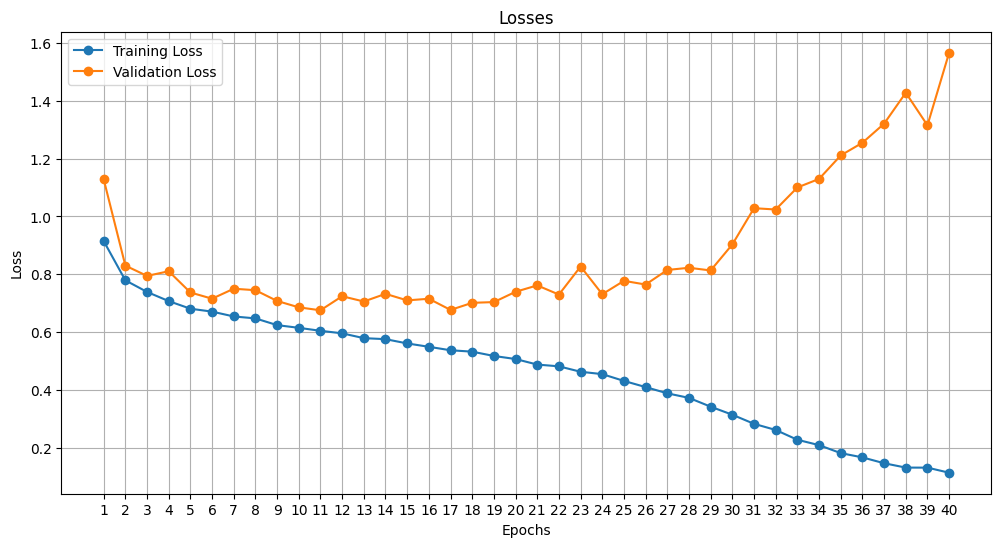

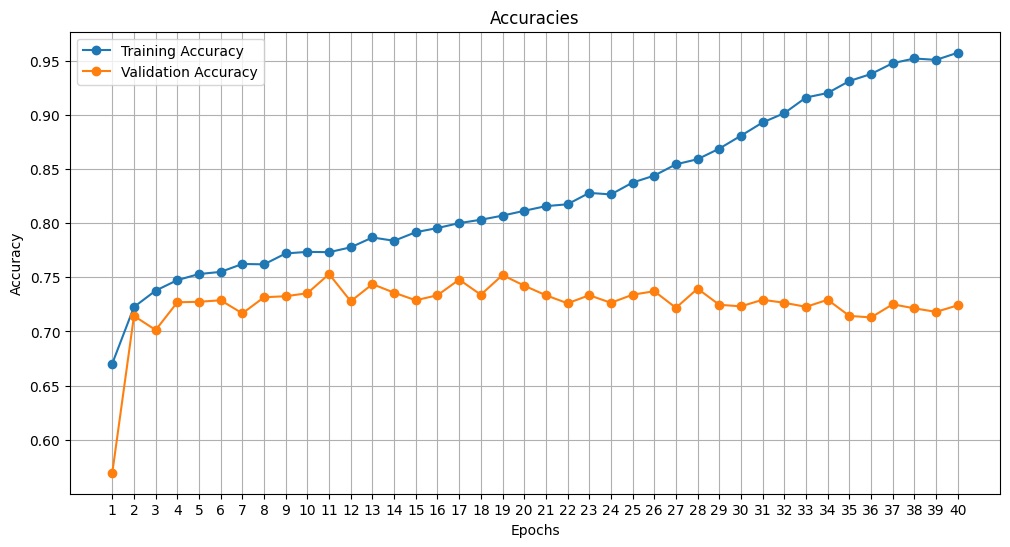

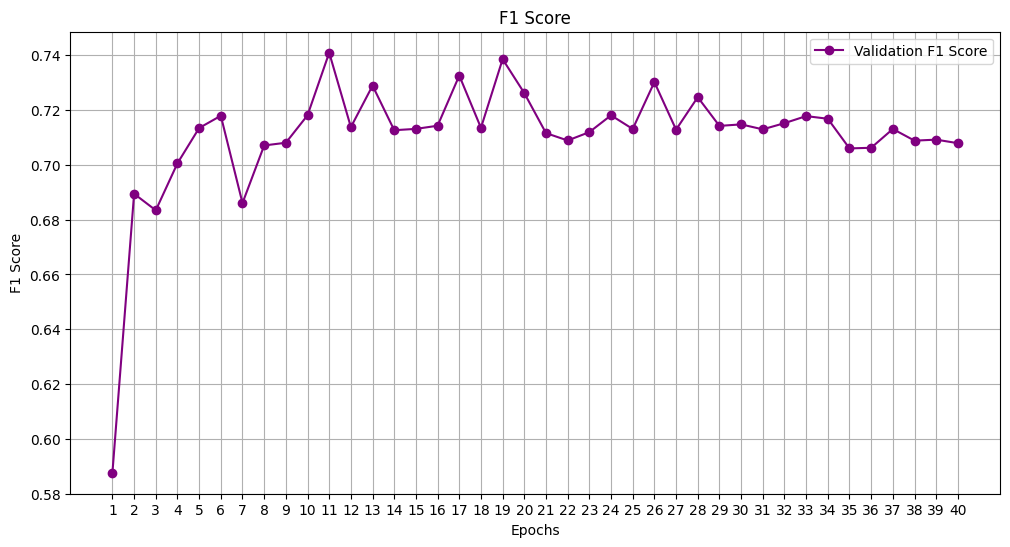

In [91]:
plot_loss_accuracy(training_losses_1d, validation_losses_1d, train_accuracies_1d, val_accuracies_1d, f1_scores_1d)

Precision: 0.7207
Recall: 0.7368
F1 Score: 0.7216
Test Accuracy: 73.68%

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.07      0.12        86
           1       0.77      0.67      0.72       429
           2       0.79      0.92      0.85       963
           3       0.64      0.57      0.60       335
           4       0.62      0.64      0.63       345

    accuracy                           0.74      2158
   macro avg       0.64      0.57      0.58      2158
weighted avg       0.72      0.74      0.72      2158



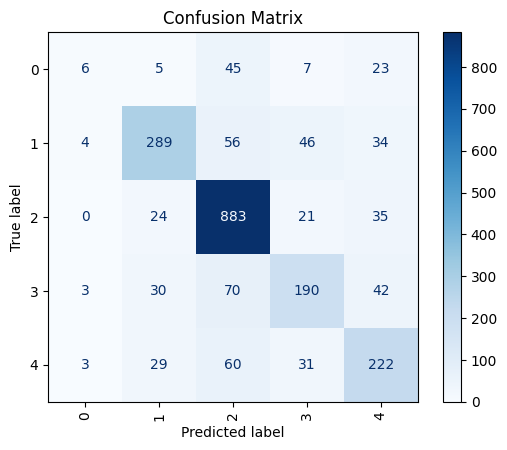

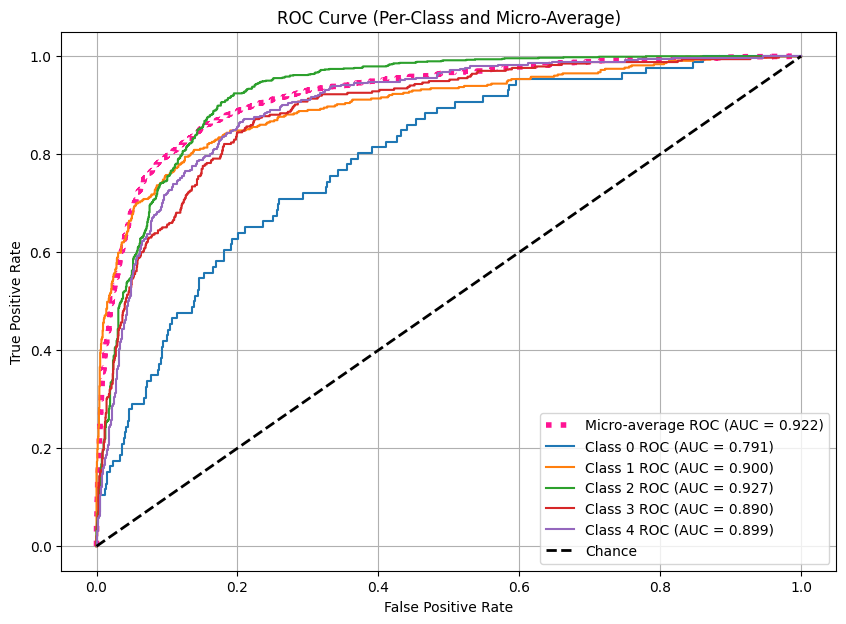

In [92]:
test_model(model_1d, test_loader_1d, device, num_classes)

#### Section 4.4 Resnet1D

In [93]:
from models.resnet1d import resnet1d18

model1d=resnet1d18(input_channels=12, num_classes=num_classes, kernel_size=[3,3])
model1d.to(device)
print(model1d)

ResNet1d(
  (0): Conv1d(12, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_si

In [94]:
optimizer = optim.Adam(model1d.parameters(), lr=0.001)
training_losses1d, validation_losses1d, f1_scores1d, train_accuracies1d, val_accuracies1d=train_model(model1d, train_loader_1d, val_loader_1d, device, max_num_epochs, criterion, optimizer)

Epoch [1/40], Train Loss: 0.9450, Train Accuracy: 0.6634, Validation Loss: 0.7911, Validation Accuracy: 0.7041, Validation F1 Score: 0.6867
Epoch [2/40], Train Loss: 0.7909, Train Accuracy: 0.7185, Validation Loss: 0.7405, Validation Accuracy: 0.7237, Validation F1 Score: 0.7089
Epoch [3/40], Train Loss: 0.7456, Train Accuracy: 0.7323, Validation Loss: 0.7442, Validation Accuracy: 0.7297, Validation F1 Score: 0.7174
Epoch [4/40], Train Loss: 0.7269, Train Accuracy: 0.7374, Validation Loss: 0.7917, Validation Accuracy: 0.6938, Validation F1 Score: 0.6668
Epoch [5/40], Train Loss: 0.7025, Train Accuracy: 0.7463, Validation Loss: 0.7214, Validation Accuracy: 0.7293, Validation F1 Score: 0.7095
Epoch [6/40], Train Loss: 0.6852, Train Accuracy: 0.7506, Validation Loss: 0.7214, Validation Accuracy: 0.7330, Validation F1 Score: 0.7278
Epoch [7/40], Train Loss: 0.6746, Train Accuracy: 0.7523, Validation Loss: 0.7349, Validation Accuracy: 0.7251, Validation F1 Score: 0.7042
Epoch [8/40], Train 

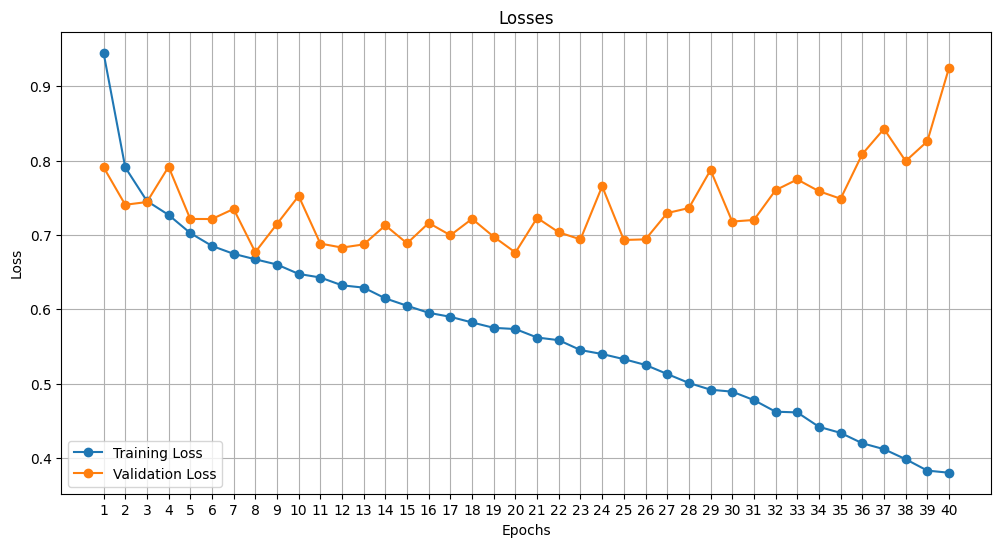

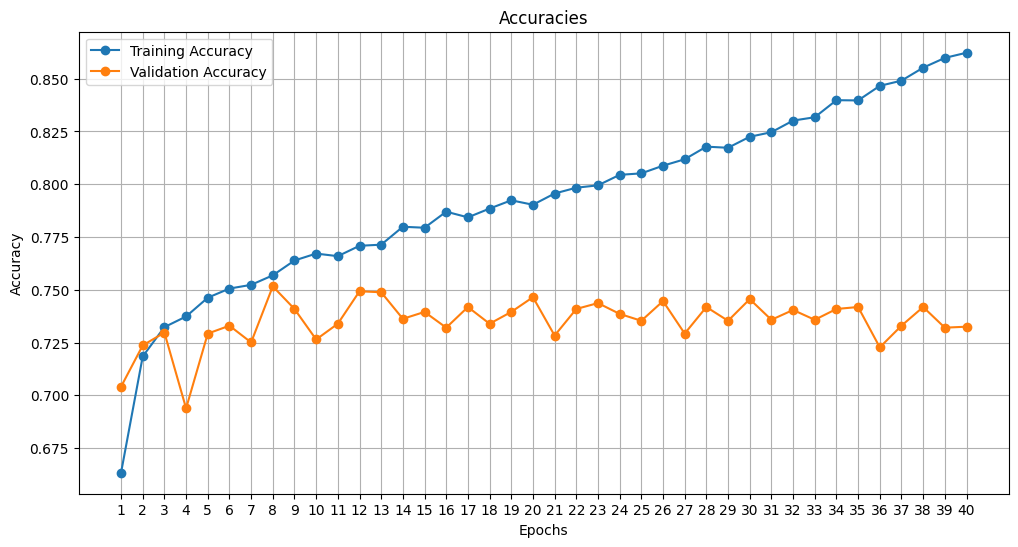

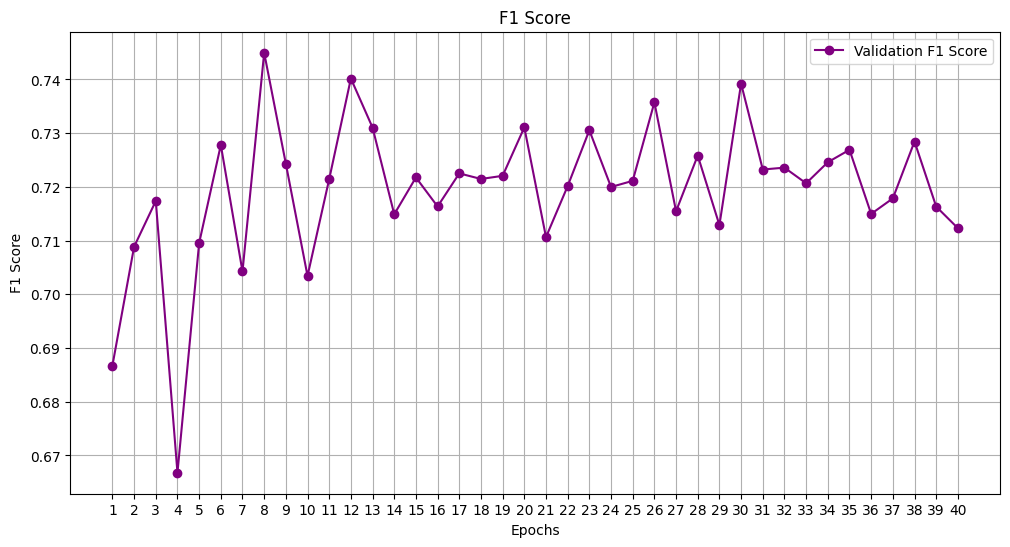

In [95]:
plot_loss_accuracy(training_losses1d, validation_losses1d, train_accuracies1d, val_accuracies1d, f1_scores1d)

Precision: 0.7185
Recall: 0.7326
F1 Score: 0.7132
Test Accuracy: 73.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.06      0.10        86
           1       0.80      0.66      0.73       429
           2       0.77      0.94      0.84       963
           3       0.67      0.48      0.56       335
           4       0.61      0.66      0.64       345

    accuracy                           0.73      2158
   macro avg       0.65      0.56      0.57      2158
weighted avg       0.72      0.73      0.71      2158



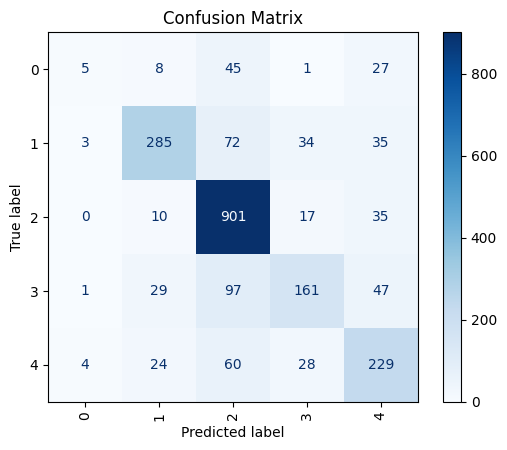

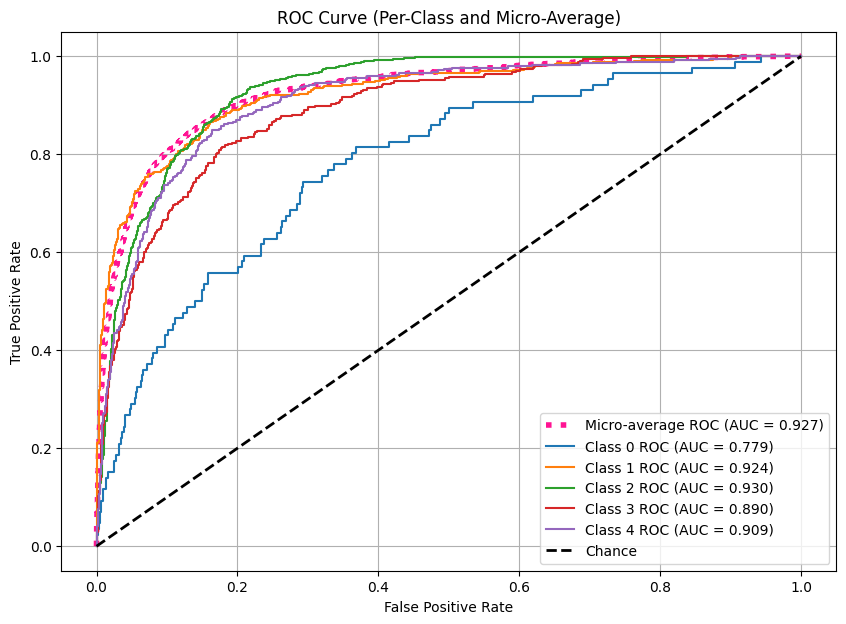

In [97]:
test_model(model1d, test_loader_1d, device, num_classes)

#### Section 4.5 xResnet

In [96]:
from models.xresnet1d import xresnet1d101

model_xres_1d=xresnet1d101(input_channels=12, num_classes=num_classes)
model_xres_1d.to(device)
print(model_xres_1d)

XResNet1d(
  (0): ConvLayer(
    (0): Conv1d(12, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): ConvLayer(
          (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
    

In [98]:
optimizer = optim.Adam(model_xres_1d.parameters(), lr=0.001)
training_losses_xres_1d, validation_losses_xres_1d, f1_scores_xres_1d, train_accuracies_xres_1d, val_accuracies_xres_1d=train_model(model_xres_1d, train_loader_1d, val_loader_1d, device, max_num_epochs, criterion, optimizer)

Epoch [1/40], Train Loss: 1.2076, Train Accuracy: 0.5999, Validation Loss: 0.8781, Validation Accuracy: 0.6775, Validation F1 Score: 0.6428
Epoch [2/40], Train Loss: 0.9078, Train Accuracy: 0.6806, Validation Loss: 0.8324, Validation Accuracy: 0.6999, Validation F1 Score: 0.6719
Epoch [3/40], Train Loss: 0.8153, Train Accuracy: 0.7116, Validation Loss: 0.7968, Validation Accuracy: 0.7134, Validation F1 Score: 0.6878
Epoch [4/40], Train Loss: 0.7668, Train Accuracy: 0.7218, Validation Loss: 0.7763, Validation Accuracy: 0.7139, Validation F1 Score: 0.6852
Epoch [5/40], Train Loss: 0.7461, Train Accuracy: 0.7300, Validation Loss: 0.7467, Validation Accuracy: 0.7190, Validation F1 Score: 0.7021
Epoch [6/40], Train Loss: 0.7169, Train Accuracy: 0.7392, Validation Loss: 0.7315, Validation Accuracy: 0.7167, Validation F1 Score: 0.7000
Epoch [7/40], Train Loss: 0.7078, Train Accuracy: 0.7456, Validation Loss: 0.7660, Validation Accuracy: 0.7297, Validation F1 Score: 0.7078
Epoch [8/40], Train 

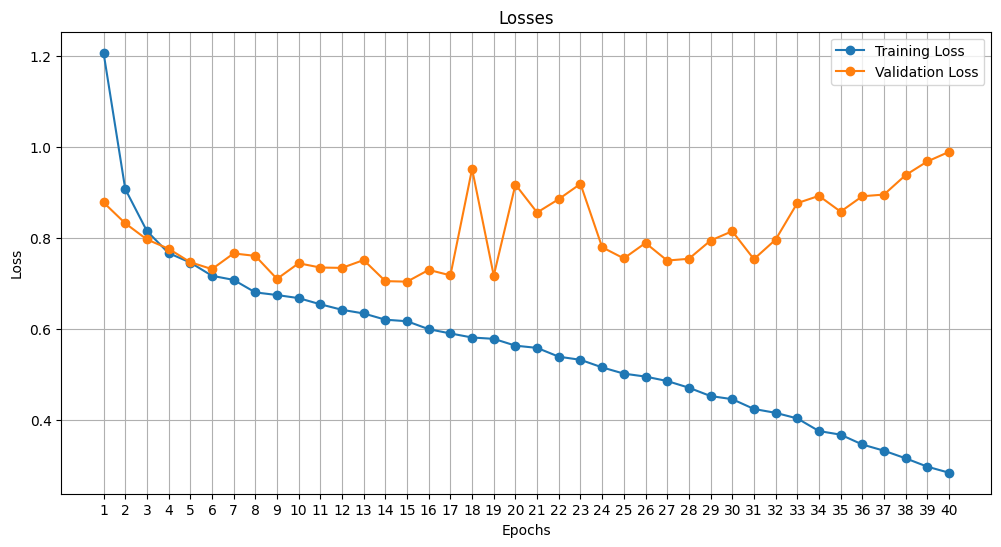

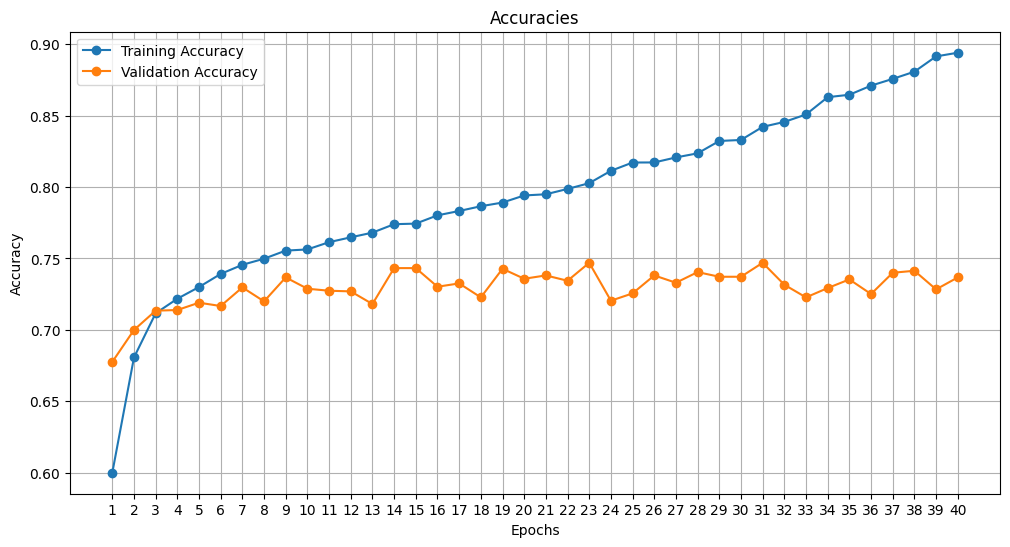

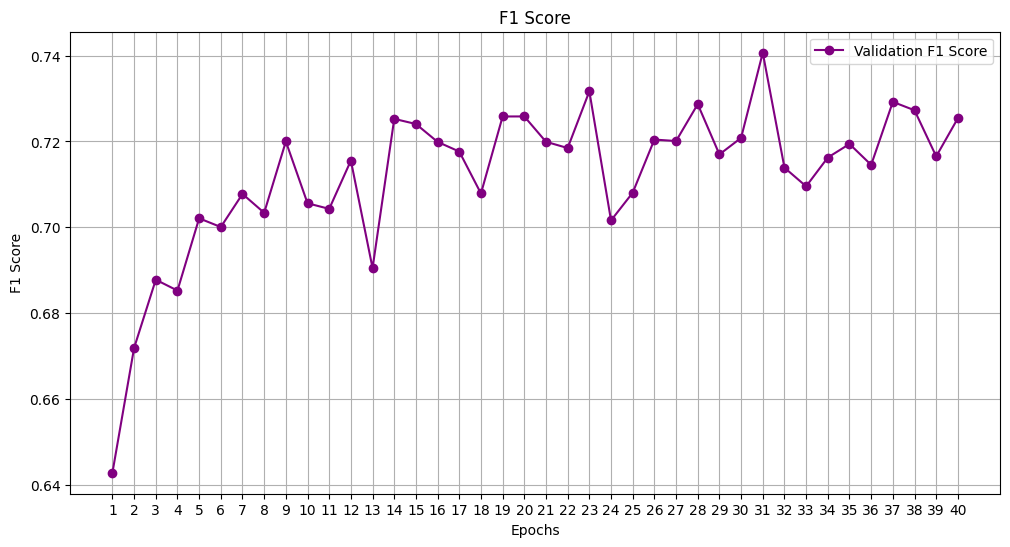

In [99]:
plot_loss_accuracy(training_losses_xres_1d, validation_losses_xres_1d, train_accuracies_xres_1d, val_accuracies_xres_1d, f1_scores_xres_1d)

Precision: 0.7101
Recall: 0.7275
F1 Score: 0.7132
Test Accuracy: 72.75%

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.13      0.18        86
           1       0.72      0.72      0.72       429
           2       0.79      0.91      0.85       963
           3       0.64      0.46      0.54       335
           4       0.64      0.64      0.64       345

    accuracy                           0.73      2158
   macro avg       0.62      0.57      0.58      2158
weighted avg       0.71      0.73      0.71      2158



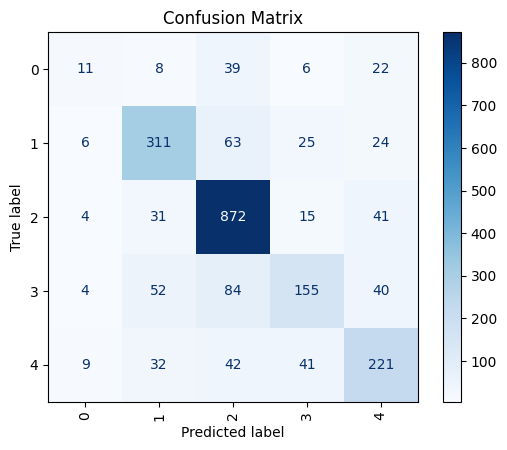

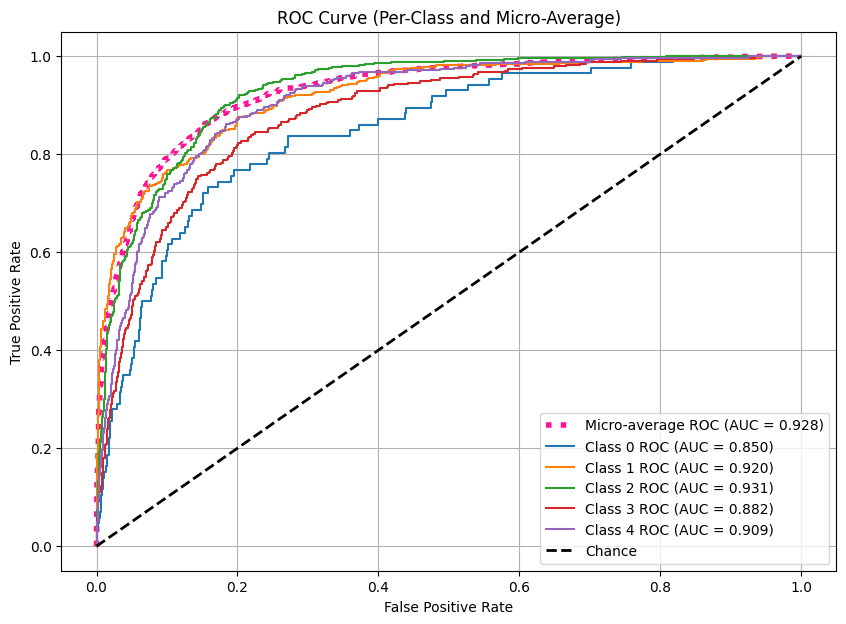

In [100]:
test_model(model_xres_1d, test_loader_1d, device, num_classes)

#### Section 4.6 Inception1d

In [101]:
from models.inception1d import inception1d

model_incep_1d=inception1d(input_channels=12, num_classes=num_classes)
model_incep_1d.to(device)
print(model_incep_1d)

Inception1d(
  (layers): Sequential(
    (0): InceptionBackbone(
      (im): ModuleList(
        (0): InceptionBlock1d(
          (bottleneck): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          (convs): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (conv_bottle): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (bn_relu): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
          )
        )
        (1-5): 5 x InceptionBlock1d(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,

In [102]:
optimizer = optim.Adam(model_incep_1d.parameters(), lr=0.001)
training_losses_incep_1d, validation_losses_incep_1d, f1_scores_incep_1d, train_accuracies_incep_1d, val_accuracies_incep_1d=train_model(model_incep_1d, train_loader_1d, val_loader_1d, device, max_num_epochs, criterion, optimizer)

Epoch [1/40], Train Loss: 0.9465, Train Accuracy: 0.6578, Validation Loss: 0.8017, Validation Accuracy: 0.7190, Validation F1 Score: 0.6957
Epoch [2/40], Train Loss: 0.8127, Train Accuracy: 0.7086, Validation Loss: 0.7831, Validation Accuracy: 0.7218, Validation F1 Score: 0.6965
Epoch [3/40], Train Loss: 0.7717, Train Accuracy: 0.7208, Validation Loss: 0.7697, Validation Accuracy: 0.7279, Validation F1 Score: 0.7091
Epoch [4/40], Train Loss: 0.7446, Train Accuracy: 0.7320, Validation Loss: 0.7689, Validation Accuracy: 0.7181, Validation F1 Score: 0.6963
Epoch [5/40], Train Loss: 0.7248, Train Accuracy: 0.7365, Validation Loss: 0.7562, Validation Accuracy: 0.7251, Validation F1 Score: 0.7054
Epoch [6/40], Train Loss: 0.7098, Train Accuracy: 0.7443, Validation Loss: 0.7430, Validation Accuracy: 0.7316, Validation F1 Score: 0.7122
Epoch [7/40], Train Loss: 0.7034, Train Accuracy: 0.7462, Validation Loss: 0.7272, Validation Accuracy: 0.7307, Validation F1 Score: 0.7093
Epoch [8/40], Train 

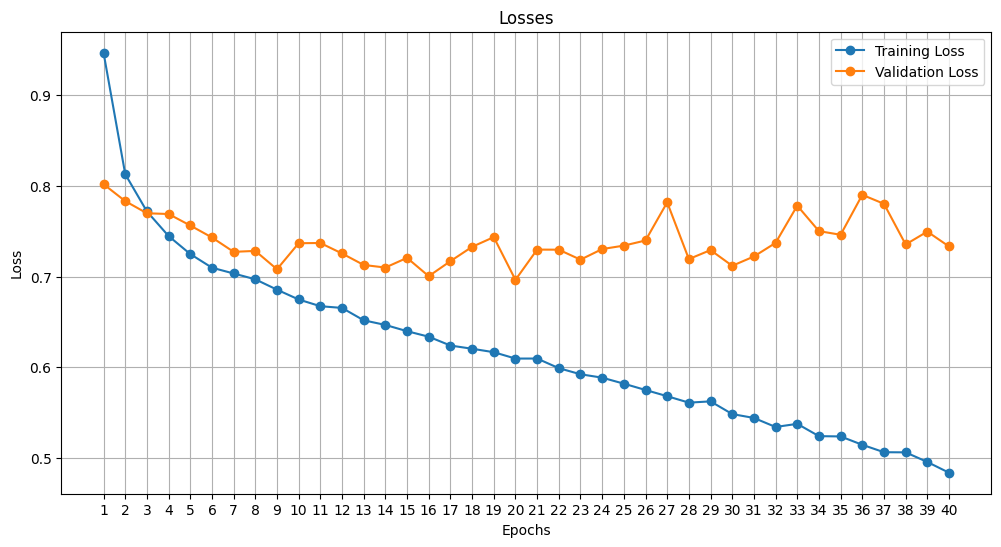

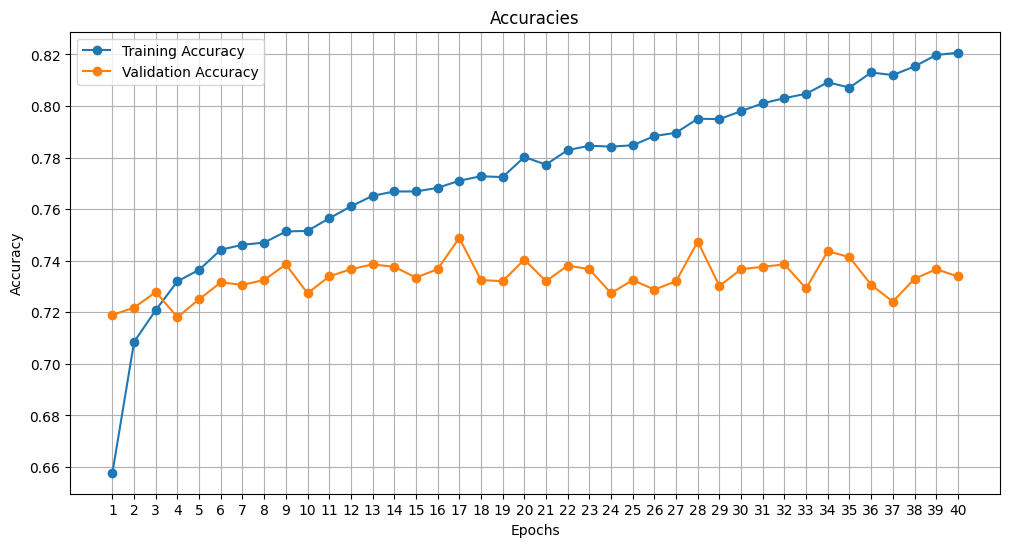

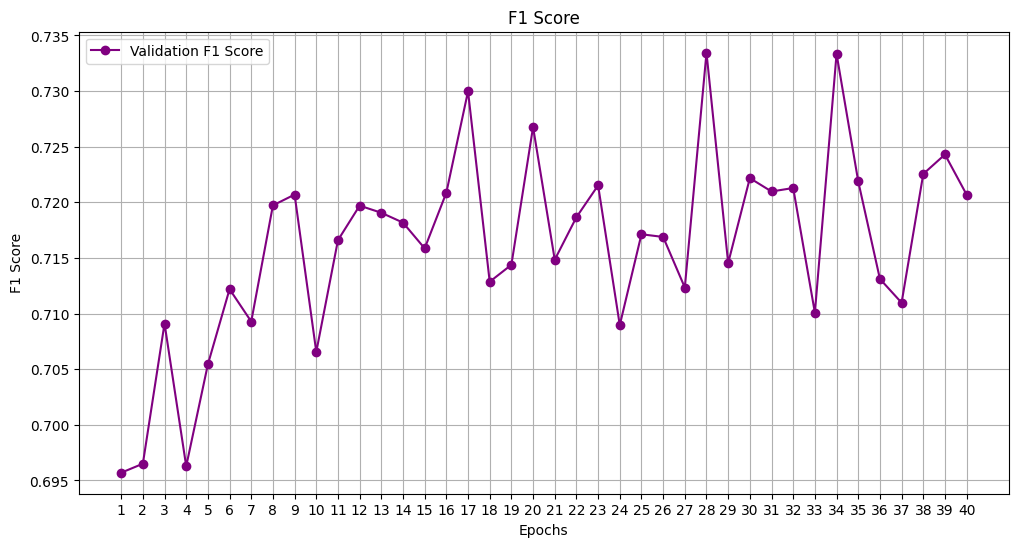

In [103]:
plot_loss_accuracy(training_losses_incep_1d, validation_losses_incep_1d, train_accuracies_incep_1d, val_accuracies_incep_1d, f1_scores_incep_1d)

Precision: 0.7323
Recall: 0.7447
F1 Score: 0.7318
Test Accuracy: 74.47%

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.08      0.14        86
           1       0.77      0.65      0.71       429
           2       0.81      0.91      0.86       963
           3       0.64      0.65      0.65       335
           4       0.62      0.65      0.64       345

    accuracy                           0.74      2158
   macro avg       0.65      0.59      0.60      2158
weighted avg       0.73      0.74      0.73      2158



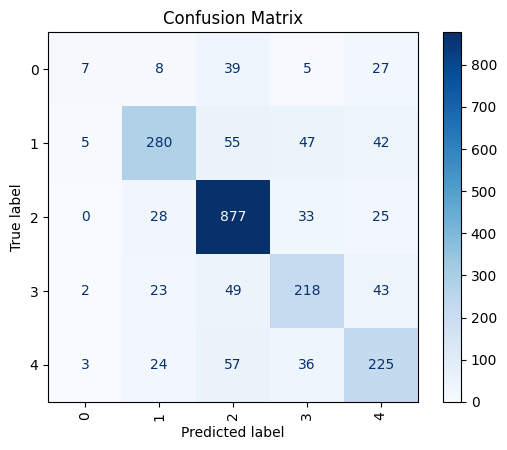

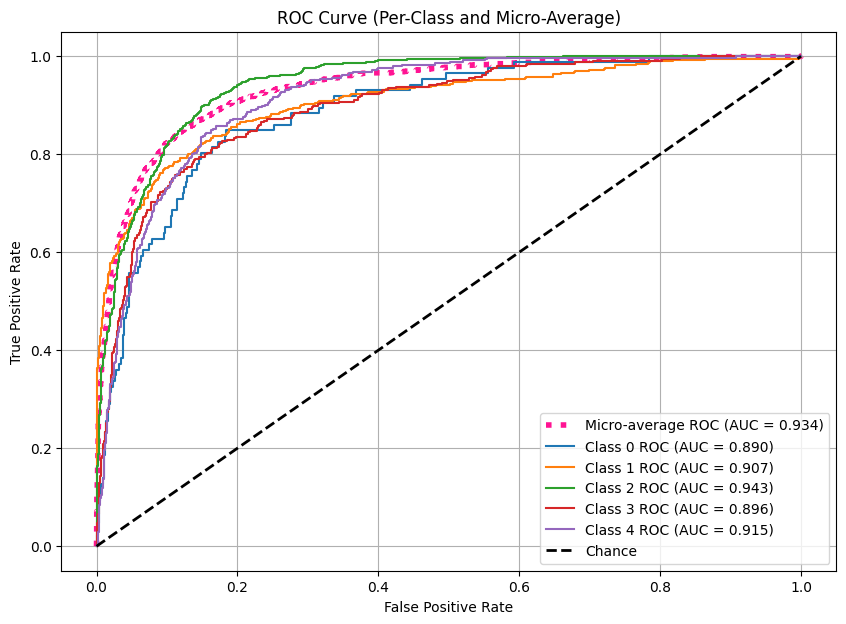

In [104]:
test_model(model_incep_1d, test_loader_1d, device, num_classes)

# Implementation of LSTM

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Define the output layer
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_len, hidden_size * num_directions)

        # Take the output from the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size * num_directions)

        # Pass through the fully connected layer
        out = self.fc(out)  # (batch_size, num_classes)
        return out

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128, num_classes)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)  # Change shape to (batch_size, input_size, seq_len)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.mean(dim=2)  # Global average pooling
        x = self.fc(x)
        return x

In [ ]:
hidden_size = 128  
num_layers = 2     
num_classes = 5    
input_size = 12    

model_lstm = LSTMClassifier(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes,
    bidirectional=False  
)
model_lstm.to(device)
print(model_lstm)


In [ ]:
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)
training_losses_lstm, validation_losses_lstm, f1_scores_lstm, train_accuracies_lstm, val_accuracies_lstm=train_model(model_lstm, train_loader_1d, val_loader_1d, device, max_num_epochs, criterion, optimizer)

In [ ]:
plot_loss_accuracy(training_losses_lstm, validation_losses_lstm, train_accuracies_lstm, val_accuracies_lstm, f1_scores_lstm)

In [ ]:
test_model(model_lstm, test_loader_1d, device, num_classes)

In [ ]:
input_size = 12     
num_classes = 5      

model_CNN = CNNClassifier(
    input_size=input_size,
    num_classes=num_classes
)
model_CNN.to(device)
print(model_CNN)

In [ ]:
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)
training_losses_CNN, validation_losses_CNN, f1_scores_CNN, train_accuracies_CNN, val_accuracies_CNN=train_model(model_CNN, train_loader_1d, val_loader_1d, device, max_num_epochs, criterion, optimizer)

In [ ]:
plot_loss_accuracy(training_losses_CNN, validation_losses_CNN, train_accuracies_CNN, val_accuracies_CNN, f1_scores_CNN)

In [ ]:
test_model(model_CNN, test_loader_1d, device, num_classes)